In [2]:
getwd()
library(tidyverse)
library(Seurat)
library(here)
library(harmony)
library(viridis)
library(RColorBrewer)
library(Polychrome)
PurpleAndYellow()
library(ComplexHeatmap)
library(devtools)
library(presto)
library(dplyr)
library(ggplot2)
library(ggpubr)
library(Polychrome)
setwd("/liulab/galib/dlbcl_manuscript/")
source('scripts/scplot.R')
kelly = kelly.colors(12)
names(kelly) = NULL

[1] "/liulab/galib/dlbcl_manuscript/scripts/10_infercnv"

Warning message:
“package ‘tidyverse’ was built under R version 4.1.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6      ✔ purrr   0.3.4 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.0      ✔ stringr 1.4.1 
✔ readr   2.1.2      ✔ forcats 0.5.1 

Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
Warning message:
“package ‘forcats’ was built under R version 4.1.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching SeuratObject

Attaching sp

here() starts at /liulab/galib/dlbcl_manuscript

Warning message:
“package ‘harmony’ was built under R version 4.1.3”
Loading required package: Rcpp

Warning message:
“package ‘Rcpp’ was built under R version 4.1.2”
Loading required package: viridisLite

Warning message:
“package ‘RColorBrewer

[1] "#FF00FF" "#F400F4" "#EA00EA" "#DF00DF" "#D500D5" "#CA00CA" "#BF00BF"
 [8] "#B500B5" "#AA00AA" "#9F009F" "#950095" "#8A008A" "#800080" "#750075"
[15] "#6A006A" "#600060" "#550055" "#4A004A" "#400040" "#350035" "#2B002B"
[22] "#200020" "#150015" "#0B000B" "#000000" "#000000" "#0B0B00" "#151500"
[29] "#202000" "#2B2B00" "#353500" "#404000" "#4A4A00" "#555500" "#606000"
[36] "#6A6A00" "#757500" "#808000" "#8A8A00" "#959500" "#9F9F00" "#AAAA00"
[43] "#B5B500" "#BFBF00" "#CACA00" "#D4D400" "#DFDF00" "#EAEA00" "#F4F400"
[50] "#FFFF00"

Warning message:
“package ‘ComplexHeatmap’ was built under R version 4.1.3”
Loading required package: grid

ComplexHeatmap version 2.10.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero effort. Have a try!

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))


Loading required package: usethis

Warning message:
“package ‘presto’ was built under R version 4.1.3”
Loading required package: data.table


Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The

In [3]:
B_cell<- readRDS("./data/objects/B_cell_final.rds")

In [19]:
poolids_annot<- B_cell@meta.data %>% distinct(pool_id, sample_id, genotype, age)
poolids_annot_non_sick<- B_cell@meta.data %>% distinct(pool_id, sample_id, genotype, age)  %>% filter(genotype != 'WT', age!='sick')
poolids_annot_sick<- B_cell@meta.data %>% distinct(pool_id, sample_id, genotype, age)  %>% filter(genotype != 'WT', age == 'sick')

In [20]:
dt_annot<- poolids_annot_non_sick

In [21]:
inpath = '/liulab/galib/mouse_scRNAseq_margaret/data/infercnv/inferCNV_out_new/'

nPC=5

for (i in c(1:nrow(dt_annot))){
        
    poolid = dt_annot$pool_id[i]
    sample_id = dt_annot$sample_id[i]
    genotype = dt_annot$genotype[i]
    age = dt_annot$age[i]
    
    genotype_new<- gsub(genotype, pattern = '/[-+]', replacement = "")  %>% 
        gsub(pattern = ';', replacement = "_")  %>% gsub(pattern = '-', replacement = "")

    infercnv_obj<- readRDS(paste0(inpath, poolid, '/run.final.infercnv_obj'))
    mtx_obs<- infercnv_obj@expr.data[,infercnv_obj@observation_grouped_cell_indices[[genotype]]]
    mtx_ref<- infercnv_obj@expr.data[,infercnv_obj@reference_grouped_cell_indices[['WT']]]
    
    # downsample WT cells
    mtx_ref<- mtx_ref[,sample(ncol(mtx_ref), ncol(mtx_obs))]
    message('obs dimension:', dim(mtx_obs)[1], " " ,dim(mtx_obs)[2])
    message('ref dimension:', dim(mtx_ref)[1], " ", dim(mtx_ref)[2])
    
    mtx = cbind(mtx_obs, mtx_ref)
    
    obj<- CreateSeuratObject(counts = mtx, project = "infercnv", min.cells = 0, min.features = 0)
    obj@meta.data$genotype<- c(rep(genotype, ncol(mtx_obs)), rep('WT', ncol(mtx_ref)))
    
    message('creating Seurat obj...')
    obj<- FindVariableFeatures(obj, selection.method = "vst", nfeatures = 2000) %>% 
                ScaleData(do.scale = FALSE, do.center = FALSE)  %>% RunPCA()
    
    ElbowPlot(obj, ndims = 15, reduction = "pca") 
    ggsave(paste0("./results/figures/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_elbow_", nPC,  ".pdf"), width = 5, height = 4)
    
    obj <- FindNeighbors(obj, dims = 1:nPC)  %>%  FindClusters(resolution = 0.6)  %>% RunUMAP(dims = 1:nPC)

    DimPlot(obj, reduction = "pca", group.by = "genotype")
    ggsave(paste0("./results/figures/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_pca_by_genotype_PC", nPC,  ".pdf"), width = 5, height = 4)

    DimPlot(obj, reduction = "umap", group.by = "genotype")
    ggsave(paste0("./results/figures/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_umap_by_genotype_PC", nPC,  ".pdf"), width = 5, height = 4)
   
    DimPlot(obj, reduction = "umap", label = TRUE)
    ggsave(paste0("./results/figures/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_umap_by_clusterid_PC", nPC,  ".pdf"), width = 5, height = 4)
    
    
    df<- obj@meta.data %>%
        count(seurat_clusters, genotype, name = "n_cells", .drop = FALSE) %>%
        complete(seurat_clusters, genotype, fill = list(n_cells = 0))  %>%
        left_join(obj@meta.data  %>% count(seurat_clusters, name = "total"), by = "seurat_clusters")  %>% 
        mutate(percentage = n_cells/total)
    
    clusterid_fact = df  %>% distinct(seurat_clusters) 
    clusterid_fact$percentage = rep(0, nrow(clusterid_fact))
    rownames(clusterid_fact) = clusterid_fact$seurat_clusters
    wt_c = df  %>% filter(genotype == "WT")  %>% pull(seurat_clusters)  %>% as.character()
    wt_p = df  %>% filter(genotype == "WT")  %>% pull(percentage)
    clusterid_fact[wt_c, 'percentage']=wt_p

    clusterid_fact<- clusterid_fact  %>% arrange(percentage)  %>% pull(seurat_clusters)

    col_4 <- c('#f3c300', '#222222')
    
    df  %>% 
        mutate(seurat_clusters = factor(seurat_clusters, levels = clusterid_fact))  %>% 
        ggplot(aes(x = seurat_clusters, y = percentage, fill = genotype)) +
        geom_bar(stat = "identity", position = 'stack') +
        scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
        scale_fill_manual(values = col_4) +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
        labs(x = "Cluster", y = "Percentage of cells per cluster", fill = "genotype")

    ggsave(paste0("./results/figures/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_barplot_percentage_of_cells_per_cluster_PC", nPC,  ".pdf"), width = 5, height = 4)
    
    
    message('overlaying infercnv clusterids on heatmap...')
    mtx_obs = t(mtx_obs)
    gene_position = infercnv_obj@gene_order

    row_annotation = data.frame(clusterID = obj@meta.data[rownames(mtx_obs), "seurat_clusters"])
    rownames(row_annotation) = rownames(mtx_obs)
    row_annotation<- row_annotation  %>% arrange(clusterID)

    clusterID_cols= createPalette(length(unique(row_annotation$clusterID)), c("#ff0000", "#00ff00", "#0000ff"))[c(1:length(unique(row_annotation$clusterID)))]%>% unname()
    clusterID_cols = setNames(clusterID_cols, unique(row_annotation$clusterID))
    right_annotation <- rowAnnotation(clusterID = row_annotation$clusterID, 
                                      col = list(clusterID= clusterID_cols))

    cnv_col_fun<- circlize::colorRamp2(c(1 - max(abs(mtx_obs - 1)), 1, 1 + max(abs(mtx_obs - 1))), c("blue", "white", "red"))
    cnv_col_fun<- circlize::colorRamp2(c(0.8, 1, 1.2), c("blue", "white", "red"))

    ht = Heatmap(mtx_obs[rownames(row_annotation),],
            name = paste0(poolid, '_' , sample_id),
            border_gp = gpar(col = "black"),
            column_split = factor(gene_position[colnames(mtx_obs), 'chr'], levels = unique(gene_position[['chr']])),
            column_title_rot = 90,
            column_title_gp = gpar(fontsize = 6),
            column_gap = unit(0.1, "mm"),
            cluster_rows = FALSE, cluster_columns = FALSE, 
            show_row_names = FALSE, show_column_names = FALSE, 
            right_annotation = right_annotation,
            show_heatmap_legend = TRUE,
            col = cnv_col_fun)


    pdf(paste0("./results/figures/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_heatmap_with_inferCNV_clusterid_PC", nPC,  ".pdf"), width = 10, height = 6)
    draw(ht)
    dev.off()
    
    malig_clusters<- df  %>% filter(genotype == 'WT', percentage<=0.25)  %>% pull(seurat_clusters)
    malig_cells<- obj@meta.data  %>% filter(seurat_clusters %in% malig_clusters)  %>% rownames()
    message(malig_clusters)
    obj@meta.data$inferCNV<- rep('neg', nrow(obj@meta.data))
    obj@meta.data[malig_cells, 'inferCNV'] = 'pos'
    saveRDS(object = obj, file = paste0("./data/infercnv/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_infercnv.obj"))
    
    write.table(x = malig_cells, file = paste0("./data/infercnv/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_PC", nPC,  ".tsv"),
            quote = FALSE, sep = '\t', row.names = FALSE, col.names = FALSE)

}

obs dimension:4760 2279

ref dimension:4760 2279

creating Seurat obj...

PC_ 1 
Positive:  Ndufb7, Pkn1, Tecr, Dnajb1, Rab8a, Tpm4, Cyp4f18, Lamb3, Fcho1, Cr2 
	   Jak3, Lpgat1, Cr1l, Traf5, Marc2, Traf3ip3, Colgalt1, Mia3, Iars2, Ints7 
	   Ppp2r5a, Fam129c, Angel2, Eprs, Nenf, Brox, Degs1, Aida, Pgls, Srp9 
Negative:  H2-D1, Ddx39b, H2-Q4, Tubb5, Csnk2b, Abhd16a, Mdc1, Nfkbil1, Hspa1a, Clic1 
	   Ltb, Vars, Prrc2a, Hspa1b, Bag6, Lsm2, 1110038B12Rik, Neu1, Nrm, Ndufa3 
	   Prpf31, Dhx16, Cnot3, Mrps18b, Mboat7, Pbx2, Myadm, Ppp1r18, Ehmt2, Skiv2l 
PC_ 2 
Positive:  Zmat5, Pes1, Uqcr10, Sf3a1, Pik3ip1, Ap1b1, Mtmr3, Tug1, Eif4enif1, Tbc1d10a 
	   Ccdc117, Drg1, Ewsr1, Xbp1, Mrps24, Dbnl, Nudcd3, Ogdh, Ccm2, Plek 
	   Tbrg4, Zmiz2, Purb, H2afv, Sec61g, Ppp3r1, Ikzf1, Snhg15, Myo1g, Cr2 
Negative:  H2-Eb1, H2-Eb2, H2-Aa, Gpsm3, H2-Ab1, Pbx2, H2-Ob, Rnf5, Atf6b, Tap2 
	   Stk19, Skiv2l, Ehmt2, Psmb8, Neu1, 1110038B12Rik, Hspa1b, Tap1, Hspa1a, Lsm2 
	   Psmb9, Vars, H2-DMb1, Clic1, Abhd16

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4558
Number of edges: 132336

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8002
Number of communities: 9
Elapsed time: 0 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
04:00:15 UMAP embedding parameters a = 0.9922 b = 1.112

04:00:15 Read 4558 rows and found 5 numeric columns

04:00:15 Using Annoy for neighbor search, n_neighbors = 30

04:00:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:00:16 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716549308307

04:00:16 Searching Annoy index using 1 thread, search_k = 3000

04:00:18 Annoy recall = 100%

04:00:19 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5352
Number of edges: 154513

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7970
Number of communities: 10
Elapsed time: 0 seconds


04:01:35 UMAP embedding parameters a = 0.9922 b = 1.112

04:01:35 Read 5352 rows and found 5 numeric columns

04:01:35 Using Annoy for neighbor search, n_neighbors = 30

04:01:35 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:01:36 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716539893c69

04:01:36 Searching Annoy index using 1 thread, search_k = 3000

04:01:38 Annoy recall = 100%

04:01:39 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:01:39 1 smooth knn distance failures

04:01:40 Initializing from normalized Laplacian + noise (using irlba)

04:01:41 Commencing optimization for 500 epochs, with 210186 positive edges

04:01:59 Optimization finished

Warning message:
“Setting row names on a tibble is deprecate

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5464
Number of edges: 157928

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8071
Number of communities: 10
Elapsed time: 0 seconds


04:03:04 UMAP embedding parameters a = 0.9922 b = 1.112

04:03:04 Read 5464 rows and found 5 numeric columns

04:03:04 Using Annoy for neighbor search, n_neighbors = 30

04:03:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:03:04 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716540accc9

04:03:04 Searching Annoy index using 1 thread, search_k = 3000

04:03:07 Annoy recall = 100%

04:03:08 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:03:08 1 smooth knn distance failures

04:03:09 Initializing from normalized Laplacian + noise (using irlba)

04:03:10 Commencing optimization for 500 epochs, with 214034 positive edges

04:03:28 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8174
Number of edges: 234040

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8216
Number of communities: 10
Elapsed time: 1 seconds


04:04:36 UMAP embedding parameters a = 0.9922 b = 1.112

04:04:36 Read 8174 rows and found 5 numeric columns

04:04:36 Using Annoy for neighbor search, n_neighbors = 30

04:04:36 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:04:37 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716578fa141

04:04:37 Searching Annoy index using 1 thread, search_k = 3000

04:04:41 Annoy recall = 100%

04:04:42 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:04:42 13 smooth knn distance failures

04:04:44 Initializing from normalized Laplacian + noise (using irlba)

04:04:44 Commencing optimization for 500 epochs, with 316182 positive edges

04:05:11 Optimization finished

Warning message:
“Setting row names on a tibble is deprecate

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5180
Number of edges: 150209

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7966
Number of communities: 10
Elapsed time: 0 seconds


04:06:32 UMAP embedding parameters a = 0.9922 b = 1.112

04:06:32 Read 5180 rows and found 5 numeric columns

04:06:32 Using Annoy for neighbor search, n_neighbors = 30

04:06:32 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:06:33 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716575cf1c0f

04:06:33 Searching Annoy index using 1 thread, search_k = 3000

04:06:35 Annoy recall = 100%

04:06:36 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:06:36 2 smooth knn distance failures

04:06:37 Initializing from normalized Laplacian + noise (using irlba)

04:06:38 Commencing optimization for 500 epochs, with 203422 positive edges

04:06:55 Optimization finished

Warning message:
“Setting row names on a tibble is deprecate

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8122
Number of edges: 231989

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8135
Number of communities: 9
Elapsed time: 0 seconds


04:08:02 UMAP embedding parameters a = 0.9922 b = 1.112

04:08:02 Read 8122 rows and found 5 numeric columns

04:08:02 Using Annoy for neighbor search, n_neighbors = 30

04:08:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:08:03 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165297088d0

04:08:03 Searching Annoy index using 1 thread, search_k = 3000

04:08:07 Annoy recall = 100%

04:08:08 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:08:08 5 smooth knn distance failures

04:08:09 Initializing from normalized Laplacian + noise (using irlba)

04:08:11 Commencing optimization for 500 epochs, with 313716 positive edges

04:08:38 Optimization finished

Warning message:
“Setting row names on a tibble is deprecate

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4712
Number of edges: 136396

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7901
Number of communities: 10
Elapsed time: 0 seconds


04:09:57 UMAP embedding parameters a = 0.9922 b = 1.112

04:09:57 Read 4712 rows and found 5 numeric columns

04:09:57 Using Annoy for neighbor search, n_neighbors = 30

04:09:57 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:09:58 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716527901e3c

04:09:58 Searching Annoy index using 1 thread, search_k = 3000

04:10:01 Annoy recall = 100%

04:10:01 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:10:01 2 smooth knn distance failures

04:10:02 Initializing from normalized Laplacian + noise (using irlba)

04:10:03 Commencing optimization for 500 epochs, with 185074 positive edges

04:10:19 Optimization finished

Warning message:
“Setting row names on a tibble is deprecate

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4732
Number of edges: 137158

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7984
Number of communities: 10
Elapsed time: 0 seconds


04:11:13 UMAP embedding parameters a = 0.9922 b = 1.112

04:11:13 Read 4732 rows and found 5 numeric columns

04:11:13 Using Annoy for neighbor search, n_neighbors = 30

04:11:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:11:14 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165165f8bdf

04:11:14 Searching Annoy index using 1 thread, search_k = 3000

04:11:16 Annoy recall = 100%

04:11:17 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:11:17 2 smooth knn distance failures

04:11:18 Initializing from normalized Laplacian + noise (using irlba)

04:11:19 Commencing optimization for 500 epochs, with 185006 positive edges

04:11:35 Optimization finished

Warning message:
“Setting row names on a tibble is deprecate

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4130
Number of edges: 121896

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8033
Number of communities: 10
Elapsed time: 0 seconds


04:12:30 UMAP embedding parameters a = 0.9922 b = 1.112

04:12:30 Read 4130 rows and found 5 numeric columns

04:12:30 Using Annoy for neighbor search, n_neighbors = 30

04:12:30 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:12:30 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271654c99302e

04:12:30 Searching Annoy index using 1 thread, search_k = 3000

04:12:32 Annoy recall = 100%

04:12:33 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:12:34 Initializing from normalized Laplacian + noise (using irlba)

04:12:35 Commencing optimization for 500 epochs, with 163054 positive edges

04:12:49 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3838
Number of edges: 112088

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7817
Number of communities: 10
Elapsed time: 0 seconds


04:13:36 UMAP embedding parameters a = 0.9922 b = 1.112

04:13:36 Read 3838 rows and found 5 numeric columns

04:13:36 Using Annoy for neighbor search, n_neighbors = 30

04:13:36 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:13:37 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716534da9c76

04:13:37 Searching Annoy index using 1 thread, search_k = 3000

04:13:39 Annoy recall = 100%

04:13:39 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:13:39 11 smooth knn distance failures

04:13:41 Initializing from normalized Laplacian + noise (using irlba)

04:13:41 Commencing optimization for 500 epochs, with 151650 positive edges

04:13:54 Optimization finished

Warning message:
“Setting row names on a tibble is deprecat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4556
Number of edges: 133399

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8056
Number of communities: 9
Elapsed time: 0 seconds


04:14:42 UMAP embedding parameters a = 0.9922 b = 1.112

04:14:42 Read 4556 rows and found 5 numeric columns

04:14:42 Using Annoy for neighbor search, n_neighbors = 30

04:14:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:14:42 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716577acdc6

04:14:42 Searching Annoy index using 1 thread, search_k = 3000

04:14:44 Annoy recall = 100%

04:14:45 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:14:46 Initializing from normalized Laplacian + noise (using irlba)

04:14:47 Commencing optimization for 500 epochs, with 179982 positive edges

04:15:02 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4356
Number of edges: 126527

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7834
Number of communities: 9
Elapsed time: 0 seconds


04:15:54 UMAP embedding parameters a = 0.9922 b = 1.112

04:15:54 Read 4356 rows and found 5 numeric columns

04:15:54 Using Annoy for neighbor search, n_neighbors = 30

04:15:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:15:55 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271654c3d0667

04:15:55 Searching Annoy index using 1 thread, search_k = 3000

04:15:57 Annoy recall = 100%

04:15:58 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:15:59 Initializing from normalized Laplacian + noise (using irlba)

04:16:00 Commencing optimization for 500 epochs, with 171230 positive edges

04:16:14 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5554
Number of edges: 159898

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7956
Number of communities: 10
Elapsed time: 0 seconds


04:17:08 UMAP embedding parameters a = 0.9922 b = 1.112

04:17:08 Read 5554 rows and found 5 numeric columns

04:17:08 Using Annoy for neighbor search, n_neighbors = 30

04:17:08 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:17:09 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271655b23cbff

04:17:09 Searching Annoy index using 1 thread, search_k = 3000

04:17:11 Annoy recall = 100%

04:17:12 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:17:12 2 smooth knn distance failures

04:17:13 Initializing from normalized Laplacian + noise (using irlba)

04:17:14 Commencing optimization for 500 epochs, with 217270 positive edges

04:17:32 Optimization finished

Warning message:
“Setting row names on a tibble is deprecate

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6726
Number of edges: 192779

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8168
Number of communities: 10
Elapsed time: 0 seconds


04:18:36 UMAP embedding parameters a = 0.9922 b = 1.112

04:18:36 Read 6726 rows and found 5 numeric columns

04:18:36 Using Annoy for neighbor search, n_neighbors = 30

04:18:37 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:18:38 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271651862575d

04:18:38 Searching Annoy index using 1 thread, search_k = 3000

04:18:41 Annoy recall = 100%

04:18:42 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:18:42 2 smooth knn distance failures

04:18:43 Initializing from normalized Laplacian + noise (using irlba)

04:18:44 Commencing optimization for 500 epochs, with 261548 positive edges

04:19:06 Optimization finished

Warning message:
“Setting row names on a tibble is deprecate

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3428
Number of edges: 101213

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8004
Number of communities: 9
Elapsed time: 0 seconds


04:20:14 UMAP embedding parameters a = 0.9922 b = 1.112

04:20:14 Read 3428 rows and found 5 numeric columns

04:20:14 Using Annoy for neighbor search, n_neighbors = 30

04:20:14 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:20:15 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165123cceb1

04:20:15 Searching Annoy index using 1 thread, search_k = 3000

04:20:16 Annoy recall = 100%

04:20:17 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:20:18 Initializing from normalized Laplacian + noise (using irlba)

04:20:19 Commencing optimization for 500 epochs, with 136364 positive edges

04:20:30 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3798
Number of edges: 112401

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8057
Number of communities: 10
Elapsed time: 0 seconds


04:21:13 UMAP embedding parameters a = 0.9922 b = 1.112

04:21:13 Read 3798 rows and found 5 numeric columns

04:21:13 Using Annoy for neighbor search, n_neighbors = 30

04:21:13 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:21:14 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165379293fe

04:21:14 Searching Annoy index using 1 thread, search_k = 3000

04:21:16 Annoy recall = 100%

04:21:16 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:21:18 Initializing from normalized Laplacian + noise (using irlba)

04:21:18 Commencing optimization for 500 epochs, with 151306 positive edges

04:21:31 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4034
Number of edges: 119775

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8081
Number of communities: 9
Elapsed time: 0 seconds


04:22:16 UMAP embedding parameters a = 0.9922 b = 1.112

04:22:16 Read 4034 rows and found 5 numeric columns

04:22:16 Using Annoy for neighbor search, n_neighbors = 30

04:22:16 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:22:17 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716524d755f8

04:22:17 Searching Annoy index using 1 thread, search_k = 3000

04:22:19 Annoy recall = 100%

04:22:19 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:22:21 Initializing from normalized Laplacian + noise (using irlba)

04:22:21 Commencing optimization for 500 epochs, with 161646 positive edges

04:22:35 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4104
Number of edges: 120731

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8062
Number of communities: 9
Elapsed time: 0 seconds


04:23:22 UMAP embedding parameters a = 0.9922 b = 1.112

04:23:22 Read 4104 rows and found 5 numeric columns

04:23:22 Using Annoy for neighbor search, n_neighbors = 30

04:23:22 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:23:22 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165590a9489

04:23:22 Searching Annoy index using 1 thread, search_k = 3000

04:23:24 Annoy recall = 100%

04:23:25 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:23:26 Initializing from normalized Laplacian + noise (using irlba)

04:23:27 Commencing optimization for 500 epochs, with 161900 positive edges

04:23:41 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5414
Number of edges: 159813

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8385
Number of communities: 10
Elapsed time: 0 seconds


04:24:31 UMAP embedding parameters a = 0.9922 b = 1.112

04:24:31 Read 5414 rows and found 5 numeric columns

04:24:31 Using Annoy for neighbor search, n_neighbors = 30

04:24:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:24:32 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271653e8629cb

04:24:32 Searching Annoy index using 1 thread, search_k = 3000

04:24:35 Annoy recall = 100%

04:24:35 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:24:36 10 smooth knn distance failures

04:24:37 Initializing from normalized Laplacian + noise (using irlba)

04:24:37 Commencing optimization for 500 epochs, with 213226 positive edges

04:24:55 Optimization finished

Warning message:
“Setting row names on a tibble is deprecat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4282
Number of edges: 124661

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7914
Number of communities: 8
Elapsed time: 0 seconds


04:25:54 UMAP embedding parameters a = 0.9922 b = 1.112

04:25:54 Read 4282 rows and found 5 numeric columns

04:25:54 Using Annoy for neighbor search, n_neighbors = 30

04:25:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:25:55 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716510d99539

04:25:55 Searching Annoy index using 1 thread, search_k = 3000

04:25:56 Annoy recall = 100%

04:25:57 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:25:58 Initializing from normalized Laplacian + noise (using irlba)

04:25:59 Commencing optimization for 500 epochs, with 168410 positive edges

04:26:13 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3760
Number of edges: 110104

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7968
Number of communities: 9
Elapsed time: 0 seconds


04:27:00 UMAP embedding parameters a = 0.9922 b = 1.112

04:27:00 Read 3760 rows and found 5 numeric columns

04:27:00 Using Annoy for neighbor search, n_neighbors = 30

04:27:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:27:00 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271654be206e5

04:27:00 Searching Annoy index using 1 thread, search_k = 3000

04:27:02 Annoy recall = 100%

04:27:03 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:27:03 1 smooth knn distance failures

04:27:04 Initializing from normalized Laplacian + noise (using irlba)

04:27:04 Commencing optimization for 500 epochs, with 149564 positive edges

04:27:17 Optimization finished

Warning message:
“Setting row names on a tibble is deprecate

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6080
Number of edges: 181942

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8454
Number of communities: 11
Elapsed time: 0 seconds


04:28:08 UMAP embedding parameters a = 0.9922 b = 1.112

04:28:08 Read 6080 rows and found 5 numeric columns

04:28:08 Using Annoy for neighbor search, n_neighbors = 30

04:28:08 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:28:09 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716556fd6041

04:28:09 Searching Annoy index using 1 thread, search_k = 3000

04:28:12 Annoy recall = 100%

04:28:13 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:28:14 Initializing from normalized Laplacian + noise (using irlba)

04:28:14 Commencing optimization for 500 epochs, with 239196 positive edges

04:28:35 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1944
Number of edges: 58630

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7828
Number of communities: 9
Elapsed time: 0 seconds


04:29:39 UMAP embedding parameters a = 0.9922 b = 1.112

04:29:39 Read 1944 rows and found 5 numeric columns

04:29:39 Using Annoy for neighbor search, n_neighbors = 30

04:29:39 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:29:39 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271651d9afb99

04:29:39 Searching Annoy index using 1 thread, search_k = 3000

04:29:40 Annoy recall = 100%

04:29:41 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:29:42 Initializing from normalized Laplacian + noise (using irlba)

04:29:42 Commencing optimization for 500 epochs, with 79422 positive edges

04:29:49 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2992
Number of edges: 89498

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7935
Number of communities: 9
Elapsed time: 0 seconds


04:30:17 UMAP embedding parameters a = 0.9922 b = 1.112

04:30:17 Read 2992 rows and found 5 numeric columns

04:30:17 Using Annoy for neighbor search, n_neighbors = 30

04:30:17 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:30:17 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716547e5a826

04:30:17 Searching Annoy index using 1 thread, search_k = 3000

04:30:19 Annoy recall = 100%

04:30:19 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:30:20 Initializing from normalized Laplacian + noise (using irlba)

04:30:21 Commencing optimization for 500 epochs, with 119976 positive edges

04:30:31 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2156
Number of edges: 64490

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7433
Number of communities: 8
Elapsed time: 0 seconds


04:31:04 UMAP embedding parameters a = 0.9922 b = 1.112

04:31:04 Read 2156 rows and found 5 numeric columns

04:31:04 Using Annoy for neighbor search, n_neighbors = 30

04:31:04 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:31:05 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271654508fe8

04:31:05 Searching Annoy index using 1 thread, search_k = 3000

04:31:05 Annoy recall = 100%

04:31:06 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:31:07 Initializing from normalized Laplacian + noise (using irlba)

04:31:07 Commencing optimization for 500 epochs, with 86458 positive edges

04:31:15 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heatm

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2492
Number of edges: 74589

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7825
Number of communities: 10
Elapsed time: 0 seconds


04:31:42 UMAP embedding parameters a = 0.9922 b = 1.112

04:31:42 Read 2492 rows and found 5 numeric columns

04:31:42 Using Annoy for neighbor search, n_neighbors = 30

04:31:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:31:42 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271652fa36b98

04:31:42 Searching Annoy index using 1 thread, search_k = 3000

04:31:43 Annoy recall = 100%

04:31:44 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:31:45 Initializing from normalized Laplacian + noise (using irlba)

04:31:45 Commencing optimization for 500 epochs, with 99392 positive edges

04:31:54 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 716
Number of edges: 22893

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7330
Number of communities: 6
Elapsed time: 0 seconds


04:32:20 UMAP embedding parameters a = 0.9922 b = 1.112

04:32:20 Read 716 rows and found 5 numeric columns

04:32:20 Using Annoy for neighbor search, n_neighbors = 30

04:32:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:32:20 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271654c3a1d63

04:32:20 Searching Annoy index using 1 thread, search_k = 3000

04:32:21 Annoy recall = 100%

04:32:21 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:32:22 Initializing from normalized Laplacian + noise (using irlba)

04:32:22 Commencing optimization for 500 epochs, with 29322 positive edges

04:32:25 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heatm

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2536
Number of edges: 75291

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7556
Number of communities: 7
Elapsed time: 0 seconds


04:32:43 UMAP embedding parameters a = 0.9922 b = 1.112

04:32:43 Read 2536 rows and found 5 numeric columns

04:32:43 Using Annoy for neighbor search, n_neighbors = 30

04:32:43 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:32:43 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271656e404bbe

04:32:43 Searching Annoy index using 1 thread, search_k = 3000

04:32:44 Annoy recall = 100%

04:32:45 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:32:46 Initializing from normalized Laplacian + noise (using irlba)

04:32:47 Commencing optimization for 500 epochs, with 102088 positive edges

04:32:56 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2826
Number of edges: 85546

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8037
Number of communities: 8
Elapsed time: 0 seconds


04:33:29 UMAP embedding parameters a = 0.9922 b = 1.112

04:33:29 Read 2826 rows and found 5 numeric columns

04:33:29 Using Annoy for neighbor search, n_neighbors = 30

04:33:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:33:29 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716543ffea2c

04:33:29 Searching Annoy index using 1 thread, search_k = 3000

04:33:30 Annoy recall = 100%

04:33:31 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:33:32 Initializing from normalized Laplacian + noise (using irlba)

04:33:33 Commencing optimization for 500 epochs, with 111662 positive edges

04:33:42 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4522
Number of edges: 134143

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8282
Number of communities: 11
Elapsed time: 0 seconds


04:34:20 UMAP embedding parameters a = 0.9922 b = 1.112

04:34:20 Read 4522 rows and found 5 numeric columns

04:34:20 Using Annoy for neighbor search, n_neighbors = 30

04:34:20 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:34:20 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716525f962df

04:34:20 Searching Annoy index using 1 thread, search_k = 3000

04:34:23 Annoy recall = 100%

04:34:23 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:34:25 Initializing from normalized Laplacian + noise (using irlba)

04:34:25 Commencing optimization for 500 epochs, with 177474 positive edges

04:34:41 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3902
Number of edges: 114435

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7887
Number of communities: 8
Elapsed time: 0 seconds


04:35:32 UMAP embedding parameters a = 0.9922 b = 1.112

04:35:32 Read 3902 rows and found 5 numeric columns

04:35:32 Using Annoy for neighbor search, n_neighbors = 30

04:35:32 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:35:33 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165208130f7

04:35:33 Searching Annoy index using 1 thread, search_k = 3000

04:35:35 Annoy recall = 100%

04:35:35 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:35:37 Initializing from normalized Laplacian + noise (using irlba)

04:35:37 Commencing optimization for 500 epochs, with 152300 positive edges

04:35:50 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2020
Number of edges: 60182

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7750
Number of communities: 8
Elapsed time: 0 seconds


04:36:32 UMAP embedding parameters a = 0.9922 b = 1.112

04:36:32 Read 2020 rows and found 5 numeric columns

04:36:32 Using Annoy for neighbor search, n_neighbors = 30

04:36:32 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:36:32 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165484d4d46

04:36:32 Searching Annoy index using 1 thread, search_k = 3000

04:36:33 Annoy recall = 100%

04:36:34 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:36:35 Initializing from normalized Laplacian + noise (using irlba)

04:36:35 Commencing optimization for 500 epochs, with 81946 positive edges

04:36:42 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2844
Number of edges: 85249

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8005
Number of communities: 9
Elapsed time: 0 seconds


04:37:10 UMAP embedding parameters a = 0.9922 b = 1.112

04:37:10 Read 2844 rows and found 5 numeric columns

04:37:10 Using Annoy for neighbor search, n_neighbors = 30

04:37:10 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:37:10 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716565fc714c

04:37:10 Searching Annoy index using 1 thread, search_k = 3000

04:37:11 Annoy recall = 100%

04:37:12 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:37:13 Initializing from normalized Laplacian + noise (using irlba)

04:37:13 Commencing optimization for 500 epochs, with 112504 positive edges

04:37:23 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1986
Number of edges: 61780

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8134
Number of communities: 8
Elapsed time: 0 seconds


04:37:56 UMAP embedding parameters a = 0.9922 b = 1.112

04:37:56 Read 1986 rows and found 5 numeric columns

04:37:56 Using Annoy for neighbor search, n_neighbors = 30

04:37:56 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:37:56 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271656987d01e

04:37:56 Searching Annoy index using 1 thread, search_k = 3000

04:37:57 Annoy recall = 100%

04:37:57 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:37:59 Initializing from normalized Laplacian + noise (using irlba)

04:37:59 Commencing optimization for 500 epochs, with 79906 positive edges

04:38:06 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2798
Number of edges: 85781

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8195
Number of communities: 8
Elapsed time: 0 seconds


04:38:33 UMAP embedding parameters a = 0.9922 b = 1.112

04:38:33 Read 2798 rows and found 5 numeric columns

04:38:33 Using Annoy for neighbor search, n_neighbors = 30

04:38:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:38:34 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716533dfbaaa

04:38:34 Searching Annoy index using 1 thread, search_k = 3000

04:38:35 Annoy recall = 100%

04:38:35 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:38:37 Initializing from normalized Laplacian + noise (using irlba)

04:38:37 Commencing optimization for 500 epochs, with 110530 positive edges

04:38:47 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3938
Number of edges: 120417

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8145
Number of communities: 9
Elapsed time: 0 seconds


04:39:24 UMAP embedding parameters a = 0.9922 b = 1.112

04:39:24 Read 3938 rows and found 5 numeric columns

04:39:24 Using Annoy for neighbor search, n_neighbors = 30

04:39:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:39:24 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716552e749c7

04:39:24 Searching Annoy index using 1 thread, search_k = 3000

04:39:26 Annoy recall = 100%

04:39:27 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:39:28 Initializing from normalized Laplacian + noise (using irlba)

04:39:28 Commencing optimization for 500 epochs, with 155436 positive edges

04:39:42 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4552
Number of edges: 132852

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8164
Number of communities: 10
Elapsed time: 0 seconds


04:40:30 UMAP embedding parameters a = 0.9922 b = 1.112

04:40:30 Read 4552 rows and found 5 numeric columns

04:40:30 Using Annoy for neighbor search, n_neighbors = 30

04:40:30 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:40:31 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165bfdc2b6

04:40:31 Searching Annoy index using 1 thread, search_k = 3000

04:40:33 Annoy recall = 100%

04:40:34 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:40:35 Initializing from normalized Laplacian + noise (using irlba)

04:40:36 Commencing optimization for 500 epochs, with 180068 positive edges

04:40:51 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3858
Number of edges: 114822

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8290
Number of communities: 10
Elapsed time: 0 seconds


04:41:41 UMAP embedding parameters a = 0.9922 b = 1.112

04:41:41 Read 3858 rows and found 5 numeric columns

04:41:41 Using Annoy for neighbor search, n_neighbors = 30

04:41:41 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:41:42 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165684c6d33

04:41:42 Searching Annoy index using 1 thread, search_k = 3000

04:41:43 Annoy recall = 100%

04:41:44 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:41:44 5 smooth knn distance failures

04:41:45 Initializing from normalized Laplacian + noise (using irlba)

04:41:46 Commencing optimization for 500 epochs, with 152672 positive edges

04:41:59 Optimization finished

Warning message:
“Setting row names on a tibble is deprecate

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6448
Number of edges: 187947

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8303
Number of communities: 11
Elapsed time: 0 seconds


04:42:49 UMAP embedding parameters a = 0.9922 b = 1.112

04:42:49 Read 6448 rows and found 5 numeric columns

04:42:49 Using Annoy for neighbor search, n_neighbors = 30

04:42:49 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:42:50 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271656ce5510c

04:42:50 Searching Annoy index using 1 thread, search_k = 3000

04:42:54 Annoy recall = 100%

04:42:54 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:42:55 12 smooth knn distance failures

04:42:56 Initializing from normalized Laplacian + noise (using irlba)

04:42:57 Commencing optimization for 500 epochs, with 252644 positive edges

04:43:18 Optimization finished

Warning message:
“Setting row names on a tibble is deprecat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6404
Number of edges: 188240

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8383
Number of communities: 11
Elapsed time: 0 seconds


04:44:29 UMAP embedding parameters a = 0.9922 b = 1.112

04:44:29 Read 6404 rows and found 5 numeric columns

04:44:29 Using Annoy for neighbor search, n_neighbors = 30

04:44:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:44:30 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271656939050a

04:44:30 Searching Annoy index using 1 thread, search_k = 3000

04:44:33 Annoy recall = 100%

04:44:34 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:44:34 3 smooth knn distance failures

04:44:35 Initializing from normalized Laplacian + noise (using irlba)

04:44:36 Commencing optimization for 500 epochs, with 251450 positive edges

04:44:58 Optimization finished

Warning message:
“Setting row names on a tibble is deprecate

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2914
Number of edges: 87425

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8226
Number of communities: 11
Elapsed time: 0 seconds


04:46:00 UMAP embedding parameters a = 0.9922 b = 1.112

04:46:00 Read 2914 rows and found 5 numeric columns

04:46:00 Using Annoy for neighbor search, n_neighbors = 30

04:46:00 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:46:02 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271651ae2c077

04:46:02 Searching Annoy index using 1 thread, search_k = 3000

04:46:03 Annoy recall = 100%

04:46:03 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:46:04 4 smooth knn distance failures

04:46:05 Initializing from normalized Laplacian + noise (using irlba)

04:46:05 Commencing optimization for 500 epochs, with 116992 positive edges

04:46:15 Optimization finished

Warning message:
“Setting row names on a tibble is deprecate

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3114
Number of edges: 92514

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8026
Number of communities: 10
Elapsed time: 0 seconds


04:46:51 UMAP embedding parameters a = 0.9922 b = 1.112

04:46:51 Read 3114 rows and found 5 numeric columns

04:46:51 Using Annoy for neighbor search, n_neighbors = 30

04:46:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:46:52 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716548ea9586

04:46:52 Searching Annoy index using 1 thread, search_k = 3000

04:46:53 Annoy recall = 100%

04:46:54 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:46:55 Initializing from normalized Laplacian + noise (using irlba)

04:46:55 Commencing optimization for 500 epochs, with 124374 positive edges

04:47:06 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1652
Number of edges: 50637

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7896
Number of communities: 7
Elapsed time: 0 seconds


04:47:40 UMAP embedding parameters a = 0.9922 b = 1.112

04:47:40 Read 1652 rows and found 5 numeric columns

04:47:40 Using Annoy for neighbor search, n_neighbors = 30

04:47:40 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:47:41 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271652a8eca41

04:47:41 Searching Annoy index using 1 thread, search_k = 3000

04:47:41 Annoy recall = 100%

04:47:42 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:47:43 Initializing from normalized Laplacian + noise (using irlba)

04:47:44 Commencing optimization for 500 epochs, with 65732 positive edges

04:47:50 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3076
Number of edges: 92844

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8245
Number of communities: 11
Elapsed time: 0 seconds


04:48:15 UMAP embedding parameters a = 0.9922 b = 1.112

04:48:15 Read 3076 rows and found 5 numeric columns

04:48:15 Using Annoy for neighbor search, n_neighbors = 30

04:48:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:48:16 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165637b01f

04:48:16 Searching Annoy index using 1 thread, search_k = 3000

04:48:17 Annoy recall = 100%

04:48:18 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:48:19 Initializing from normalized Laplacian + noise (using irlba)

04:48:20 Commencing optimization for 500 epochs, with 121944 positive edges

04:48:30 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6254
Number of edges: 183579

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8285
Number of communities: 10
Elapsed time: 0 seconds


04:49:15 UMAP embedding parameters a = 0.9922 b = 1.112

04:49:15 Read 6254 rows and found 5 numeric columns

04:49:15 Using Annoy for neighbor search, n_neighbors = 30

04:49:15 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:49:16 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271652359ef03

04:49:16 Searching Annoy index using 1 thread, search_k = 3000

04:49:19 Annoy recall = 100%

04:49:20 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:49:22 Initializing from normalized Laplacian + noise (using irlba)

04:49:22 Commencing optimization for 500 epochs, with 240144 positive edges

04:49:43 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3020
Number of edges: 90639

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7965
Number of communities: 7
Elapsed time: 0 seconds


04:50:47 UMAP embedding parameters a = 0.9922 b = 1.112

04:50:47 Read 3020 rows and found 5 numeric columns

04:50:47 Using Annoy for neighbor search, n_neighbors = 30

04:50:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:50:48 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165569f3f51

04:50:48 Searching Annoy index using 1 thread, search_k = 3000

04:50:49 Annoy recall = 100%

04:50:50 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:50:51 Initializing from normalized Laplacian + noise (using irlba)

04:50:51 Commencing optimization for 500 epochs, with 120432 positive edges

04:51:01 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1004
Number of edges: 30994

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7522
Number of communities: 6
Elapsed time: 0 seconds


04:51:33 UMAP embedding parameters a = 0.9922 b = 1.112

04:51:33 Read 1004 rows and found 5 numeric columns

04:51:33 Using Annoy for neighbor search, n_neighbors = 30

04:51:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:51:33 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271658e72efd

04:51:33 Searching Annoy index using 1 thread, search_k = 3000

04:51:33 Annoy recall = 100%

04:51:34 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:51:35 Initializing from normalized Laplacian + noise (using irlba)

04:51:35 Commencing optimization for 500 epochs, with 40742 positive edges

04:51:39 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heatm

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2578
Number of edges: 77978

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8026
Number of communities: 9
Elapsed time: 0 seconds


04:52:01 UMAP embedding parameters a = 0.9922 b = 1.112

04:52:01 Read 2578 rows and found 5 numeric columns

04:52:01 Using Annoy for neighbor search, n_neighbors = 30

04:52:01 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:52:01 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271655ca048bd

04:52:01 Searching Annoy index using 1 thread, search_k = 3000

04:52:02 Annoy recall = 100%

04:52:03 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:52:04 Initializing from normalized Laplacian + noise (using irlba)

04:52:04 Commencing optimization for 500 epochs, with 103116 positive edges

04:52:13 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3200
Number of edges: 98230

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8177
Number of communities: 8
Elapsed time: 0 seconds


04:52:46 UMAP embedding parameters a = 0.9922 b = 1.112

04:52:46 Read 3200 rows and found 5 numeric columns

04:52:47 Using Annoy for neighbor search, n_neighbors = 30

04:52:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:52:47 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271657c09d1fe

04:52:47 Searching Annoy index using 1 thread, search_k = 3000

04:52:48 Annoy recall = 100%

04:52:49 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:52:50 Initializing from normalized Laplacian + noise (using irlba)

04:52:51 Commencing optimization for 500 epochs, with 125520 positive edges

04:53:02 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3220
Number of edges: 95978

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8137
Number of communities: 10
Elapsed time: 0 seconds


04:53:42 UMAP embedding parameters a = 0.9922 b = 1.112

04:53:42 Read 3220 rows and found 5 numeric columns

04:53:42 Using Annoy for neighbor search, n_neighbors = 30

04:53:42 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:53:43 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271657d66f30

04:53:43 Searching Annoy index using 1 thread, search_k = 3000

04:53:44 Annoy recall = 100%

04:53:45 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:53:46 Initializing from normalized Laplacian + noise (using irlba)

04:53:46 Commencing optimization for 500 epochs, with 126760 positive edges

04:53:57 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5680
Number of edges: 168249

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8305
Number of communities: 8
Elapsed time: 0 seconds


04:54:45 UMAP embedding parameters a = 0.9922 b = 1.112

04:54:45 Read 5680 rows and found 5 numeric columns

04:54:45 Using Annoy for neighbor search, n_neighbors = 30

04:54:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:54:46 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165418e8ba4

04:54:46 Searching Annoy index using 1 thread, search_k = 3000

04:54:49 Annoy recall = 100%

04:54:49 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:54:51 Initializing from normalized Laplacian + noise (using irlba)

04:54:52 Commencing optimization for 500 epochs, with 218898 positive edges

04:55:10 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9576
Number of edges: 278014

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8436
Number of communities: 8
Elapsed time: 1 seconds


04:56:27 UMAP embedding parameters a = 0.9922 b = 1.112

04:56:27 Read 9576 rows and found 5 numeric columns

04:56:27 Using Annoy for neighbor search, n_neighbors = 30

04:56:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:56:29 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165717f2fe8

04:56:29 Searching Annoy index using 1 thread, search_k = 3000

04:56:34 Annoy recall = 100%

04:56:34 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:56:36 Initializing from normalized Laplacian + noise (using irlba)

04:56:38 Commencing optimization for 500 epochs, with 366502 positive edges

04:57:08 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 5550
Number of edges: 163604

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8171
Number of communities: 9
Elapsed time: 0 seconds


04:58:43 UMAP embedding parameters a = 0.9922 b = 1.112

04:58:43 Read 5550 rows and found 5 numeric columns

04:58:43 Using Annoy for neighbor search, n_neighbors = 30

04:58:43 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

04:58:44 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271657081e04c

04:58:44 Searching Annoy index using 1 thread, search_k = 3000

04:58:46 Annoy recall = 100%

04:58:47 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

04:58:49 Initializing from normalized Laplacian + noise (using irlba)

04:58:50 Commencing optimization for 500 epochs, with 215718 positive edges

04:59:08 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3850
Number of edges: 114981

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8081
Number of communities: 9
Elapsed time: 0 seconds


05:00:11 UMAP embedding parameters a = 0.9922 b = 1.112

05:00:11 Read 3850 rows and found 5 numeric columns

05:00:11 Using Annoy for neighbor search, n_neighbors = 30

05:00:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:00:12 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165310521b7

05:00:12 Searching Annoy index using 1 thread, search_k = 3000

05:00:14 Annoy recall = 100%

05:00:14 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:00:16 Initializing from normalized Laplacian + noise (using irlba)

05:00:16 Commencing optimization for 500 epochs, with 151230 positive edges

05:00:29 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2220
Number of edges: 68715

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8280
Number of communities: 10
Elapsed time: 0 seconds


05:01:12 UMAP embedding parameters a = 0.9922 b = 1.112

05:01:12 Read 2220 rows and found 5 numeric columns

05:01:12 Using Annoy for neighbor search, n_neighbors = 30

05:01:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:01:12 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716566240997

05:01:12 Searching Annoy index using 1 thread, search_k = 3000

05:01:13 Annoy recall = 100%

05:01:14 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:01:15 Initializing from normalized Laplacian + noise (using irlba)

05:01:16 Commencing optimization for 500 epochs, with 88682 positive edges

05:01:24 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2124
Number of edges: 64434

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7763
Number of communities: 8
Elapsed time: 0 seconds


05:01:53 UMAP embedding parameters a = 0.9922 b = 1.112

05:01:53 Read 2124 rows and found 5 numeric columns

05:01:53 Using Annoy for neighbor search, n_neighbors = 30

05:01:53 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:01:53 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271655155c547

05:01:53 Searching Annoy index using 1 thread, search_k = 3000

05:01:54 Annoy recall = 100%

05:01:55 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:01:56 Initializing from normalized Laplacian + noise (using irlba)

05:01:56 Commencing optimization for 500 epochs, with 84274 positive edges

05:02:04 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2276
Number of edges: 70180

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7983
Number of communities: 8
Elapsed time: 0 seconds


05:02:32 UMAP embedding parameters a = 0.9922 b = 1.112

05:02:32 Read 2276 rows and found 5 numeric columns

05:02:32 Using Annoy for neighbor search, n_neighbors = 30

05:02:32 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:02:33 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165418a864e

05:02:33 Searching Annoy index using 1 thread, search_k = 3000

05:02:34 Annoy recall = 100%

05:02:35 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:02:36 Initializing from normalized Laplacian + noise (using irlba)

05:02:36 Commencing optimization for 500 epochs, with 90546 positive edges

05:02:44 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

In [22]:
dt_annot<- poolids_annot_sick
inpath = '/liulab/galib/mouse_scRNAseq_margaret/data/infercnv/inferCNV_out_new/'
nPC=5

for (i in c(1:nrow(dt_annot))){
        
    poolid = dt_annot$pool_id[i]
    sample_id = dt_annot$sample_id[i]
    genotype = dt_annot$genotype[i]
    age = dt_annot$age[i]
    
    genotype_new<- gsub(genotype, pattern = '/[-+]', replacement = "")  %>% 
        gsub(pattern = ';', replacement = "_")  %>% gsub(pattern = '-', replacement = "")

    infercnv_obj<- readRDS(paste0(inpath, poolid, '_newsick/run.final.infercnv_obj'))
    mtx_obs<- infercnv_obj@expr.data[,infercnv_obj@observation_grouped_cell_indices[[genotype]]]
    mtx_ref<- infercnv_obj@expr.data[,infercnv_obj@reference_grouped_cell_indices[['WT']]]
    
    # downsample WT cells
    mtx_ref<- mtx_ref[,sample(ncol(mtx_ref), ncol(mtx_obs))]
    message('obs dimension:', dim(mtx_obs)[1], " " ,dim(mtx_obs)[2])
    message('ref dimension:', dim(mtx_ref)[1], " ", dim(mtx_ref)[2])
    
    mtx = cbind(mtx_obs, mtx_ref)
    
    obj<- CreateSeuratObject(counts = mtx, project = "infercnv", min.cells = 0, min.features = 0)
    obj@meta.data$genotype<- c(rep(genotype, ncol(mtx_obs)), rep('WT', ncol(mtx_ref)))
    
    message('creating Seurat obj...')
    obj<- FindVariableFeatures(obj, selection.method = "vst", nfeatures = 2000) %>% 
                ScaleData(do.scale = FALSE, do.center = FALSE)  %>% RunPCA()
    
    ElbowPlot(obj, ndims = 15, reduction = "pca") 
    ggsave(paste0("./results/figures/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_elbow_", nPC,  ".pdf"), width = 5, height = 4)
    
    obj <- FindNeighbors(obj, dims = 1:nPC)  %>%  FindClusters(resolution = 0.6)  %>% RunUMAP(dims = 1:nPC)

    DimPlot(obj, reduction = "pca", group.by = "genotype")
    ggsave(paste0("./results/figures/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_pca_by_genotype_PC", nPC,  ".pdf"), width = 5, height = 4)

    DimPlot(obj, reduction = "umap", group.by = "genotype")
    ggsave(paste0("./results/figures/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_umap_by_genotype_PC", nPC,  ".pdf"), width = 5, height = 4)
   
    DimPlot(obj, reduction = "umap", label = TRUE)
    ggsave(paste0("./results/figures/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_umap_by_clusterid_PC", nPC,  ".pdf"), width = 5, height = 4)
    
    df<- obj@meta.data %>%
        count(seurat_clusters, genotype, name = "n_cells", .drop = FALSE) %>%
        complete(seurat_clusters, genotype, fill = list(n_cells = 0))  %>%
        left_join(obj@meta.data  %>% count(seurat_clusters, name = "total"), by = "seurat_clusters")  %>% 
        mutate(percentage = n_cells/total)
    
    
    clusterid_fact = df  %>% distinct(seurat_clusters) 
    clusterid_fact$percentage = rep(0, nrow(clusterid_fact))
    rownames(clusterid_fact) = clusterid_fact$seurat_clusters
    wt_c = df  %>% filter(genotype == "WT")  %>% pull(seurat_clusters)  %>% as.character()
    wt_p = df  %>% filter(genotype == "WT")  %>% pull(percentage)
    clusterid_fact[wt_c, 'percentage']=wt_p

    clusterid_fact<- clusterid_fact  %>% arrange(percentage)  %>% pull(seurat_clusters)

    col_4 <- c('#f3c300', '#222222')
    
    df  %>% 
        mutate(seurat_clusters = factor(seurat_clusters, levels = clusterid_fact))  %>% 
        ggplot(aes(x = seurat_clusters, y = percentage, fill = genotype)) +
        geom_bar(stat = "identity", position = 'stack') +
        scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
        scale_fill_manual(values = col_4) +
        theme_bw() +
        theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
        labs(x = "Cluster", y = "Percentage of cells per cluster", fill = "genotype")

    ggsave(paste0("./results/figures/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_barplot_percentage_of_cells_per_cluster_PC", nPC,  ".pdf"), width = 5, height = 4)
    
    
    message('overlaying infercnv clusterids on heatmap...')
    mtx_obs = t(mtx_obs)
    gene_position = infercnv_obj@gene_order

    row_annotation = data.frame(clusterID = obj@meta.data[rownames(mtx_obs), "seurat_clusters"])
    rownames(row_annotation) = rownames(mtx_obs)
    row_annotation<- row_annotation  %>% arrange(clusterID)

    clusterID_cols= createPalette(length(unique(row_annotation$clusterID)), c("#ff0000", "#00ff00", "#0000ff"))[c(1:length(unique(row_annotation$clusterID)))]%>% unname()
    clusterID_cols = setNames(clusterID_cols, unique(row_annotation$clusterID))
    right_annotation <- rowAnnotation(clusterID = row_annotation$clusterID, 
                                      col = list(clusterID= clusterID_cols))

    cnv_col_fun<- circlize::colorRamp2(c(1 - max(abs(mtx_obs - 1)), 1, 1 + max(abs(mtx_obs - 1))), c("blue", "white", "red"))
    cnv_col_fun<- circlize::colorRamp2(c(0.8, 1, 1.2), c("blue", "white", "red"))

    ht = Heatmap(mtx_obs[rownames(row_annotation),],
            name = paste0(poolid, '_' , sample_id),
            border_gp = gpar(col = "black"),
            column_split = factor(gene_position[colnames(mtx_obs), 'chr'], levels = unique(gene_position[['chr']])),
            column_title_rot = 90,
            column_title_gp = gpar(fontsize = 6),
            column_gap = unit(0.1, "mm"),
            cluster_rows = FALSE, cluster_columns = FALSE, 
            show_row_names = FALSE, show_column_names = FALSE, 
            right_annotation = right_annotation,
            show_heatmap_legend = TRUE,
            col = cnv_col_fun)


    pdf(paste0("./results/figures/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_heatmap_with_inferCNV_clusterid_PC", nPC,  ".pdf"), width = 10, height = 6)
    draw(ht)
    dev.off()
    
    malig_clusters<- df  %>% filter(genotype == 'WT', percentage<=0.25)  %>% pull(seurat_clusters)
    malig_cells<- obj@meta.data  %>% filter(seurat_clusters %in% malig_clusters)  %>% rownames()
    obj@meta.data$inferCNV<- rep('neg', nrow(obj@meta.data))
    obj@meta.data[malig_cells, 'inferCNV'] = 'pos'
    saveRDS(object = obj, file = paste0("./data/infercnv/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_infercnv.obj"))
    
    write.table(x = malig_cells, file = paste0("./data/infercnv/10_", poolid, '_' , sample_id, '_' , genotype_new, '_' , age, "_define_inferCNV_pos_PC", nPC,  ".tsv"),
            quote = FALSE, sep = '\t', row.names = FALSE, col.names = FALSE)

}

obs dimension:4644 1657

ref dimension:4644 1657

creating Seurat obj...

PC_ 1 
Positive:  Cr2, Cr1l, Lamb3, Traf3ip3, Traf5, Lpgat1, Ints7, Nenf, Ppp2r5a, Arhgef18 
	   Angel2, Xab2, Eprs, Pet100, Iars2, Stxbp2, Trappc5, Clcf1, Ppp1ca, Pold4 
	   Marc2, Tbc1d10c, Grk2, Fcer2a, Map2k7, Kdm2a, Ptprcap, Dusp10, Rce1, Mia3 
Negative:  Ppfia1, Ppp1r21, Nap1l4, Asxl2, Ncoa1, Rab10os, Kcnq1ot1, Foxn2, Ubxn2a, Rab10 
	   Cd81, Sf3b6, Atad2b, Ldah, Itsn2, Rhob, Fbxo11, Tspan32, Pum2, Mrpl23 
	   Calm2, Hspa14, Ttc7, Prdx2, Laptm4a, Cript, Dnase2a, Lsp1, Fam107b, Rhoq 
PC_ 2 
Positive:  H2-Aa, H2-Ab1, H2-Ob, H2-Eb1, Tap2, H2-Eb2, Psmb8, Tap1, Gpsm3, Psmb9 
	   Rnf5, H2-DMb1, H2-DMb2, Atf6b, H2-DMa, Stk19, Skiv2l, Brd2, Ehmt2, H2-Oa 
	   Neu1, 1110038B12Rik, Rxrb, Hspa1b, Hspa1a, Slc39a7, Lsm2, H2-Ke6, Vars, Ring1 
Negative:  Igkv6-17, Igkv6-15, Igkv6-13, Igkv3-12, Igkv3-7, Ppil2, Igkv3-5, Mapk1, Top3b, Sdf2l1 
	   Ube2l3, Dnm1l, Pi4ka, Ube2v2, Mcm4, Med15, Fopnl, Klf6, Snap29, Pfkp 
	   Ranbp1

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3314
Number of edges: 97557

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7976
Number of communities: 8
Elapsed time: 0 seconds


05:08:31 UMAP embedding parameters a = 0.9922 b = 1.112

05:08:31 Read 3314 rows and found 5 numeric columns

05:08:31 Using Annoy for neighbor search, n_neighbors = 30

05:08:31 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:08:32 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165162fd9d3

05:08:32 Searching Annoy index using 1 thread, search_k = 3000

05:08:33 Annoy recall = 100%

05:08:34 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:08:35 Initializing from normalized Laplacian + noise (using irlba)

05:08:36 Commencing optimization for 500 epochs, with 131514 positive edges

05:08:47 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1656
Number of edges: 50410

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7833
Number of communities: 8
Elapsed time: 0 seconds


05:09:21 UMAP embedding parameters a = 0.9922 b = 1.112

05:09:21 Read 1656 rows and found 5 numeric columns

05:09:21 Using Annoy for neighbor search, n_neighbors = 30

05:09:21 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:09:22 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271653d2106a6

05:09:22 Searching Annoy index using 1 thread, search_k = 3000

05:09:22 Annoy recall = 100%

05:09:23 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:09:24 Initializing from normalized Laplacian + noise (using irlba)

05:09:24 Commencing optimization for 500 epochs, with 66740 positive edges

05:09:30 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2088
Number of edges: 65117

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8170
Number of communities: 9
Elapsed time: 0 seconds


05:09:53 UMAP embedding parameters a = 0.9922 b = 1.112

05:09:53 Read 2088 rows and found 5 numeric columns

05:09:53 Using Annoy for neighbor search, n_neighbors = 30

05:09:53 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:09:54 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271651cc1c9ec

05:09:54 Searching Annoy index using 1 thread, search_k = 3000

05:09:55 Annoy recall = 100%

05:09:55 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:09:56 Initializing from normalized Laplacian + noise (using irlba)

05:09:57 Commencing optimization for 500 epochs, with 84066 positive edges

05:10:04 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1090
Number of edges: 34536

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7721
Number of communities: 7
Elapsed time: 0 seconds


05:10:28 UMAP embedding parameters a = 0.9922 b = 1.112

05:10:28 Read 1090 rows and found 5 numeric columns

05:10:28 Using Annoy for neighbor search, n_neighbors = 30

05:10:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:10:29 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716556dbe42d

05:10:29 Searching Annoy index using 1 thread, search_k = 3000

05:10:29 Annoy recall = 100%

05:10:30 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:10:31 Initializing from normalized Laplacian + noise (using irlba)

05:10:31 Commencing optimization for 500 epochs, with 44306 positive edges

05:10:36 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 248
Number of edges: 7198

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7234
Number of communities: 4
Elapsed time: 0 seconds


05:10:51 UMAP embedding parameters a = 0.9922 b = 1.112

05:10:51 Read 248 rows and found 5 numeric columns

05:10:51 Using Annoy for neighbor search, n_neighbors = 30

05:10:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:10:52 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271656c8a9b0f

05:10:52 Searching Annoy index using 1 thread, search_k = 3000

05:10:52 Annoy recall = 100%

05:10:52 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:10:54 Initializing from normalized Laplacian + noise (using irlba)

05:10:54 Commencing optimization for 500 epochs, with 9700 positive edges

05:10:55 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heatma

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1116
Number of edges: 34700

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7387
Number of communities: 6
Elapsed time: 0 seconds


05:11:05 UMAP embedding parameters a = 0.9922 b = 1.112

05:11:05 Read 1116 rows and found 5 numeric columns

05:11:05 Using Annoy for neighbor search, n_neighbors = 30

05:11:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:11:05 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716510b7b2a2

05:11:05 Searching Annoy index using 1 thread, search_k = 3000

05:11:06 Annoy recall = 100%

05:11:06 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:11:07 Initializing from normalized Laplacian + noise (using irlba)

05:11:08 Commencing optimization for 500 epochs, with 45746 positive edges

05:11:12 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 768
Number of edges: 23313

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7625
Number of communities: 7
Elapsed time: 0 seconds


05:11:28 UMAP embedding parameters a = 0.9922 b = 1.112

05:11:28 Read 768 rows and found 5 numeric columns

05:11:28 Using Annoy for neighbor search, n_neighbors = 30

05:11:28 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:11:29 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271655fe4f1d9

05:11:29 Searching Annoy index using 1 thread, search_k = 3000

05:11:29 Annoy recall = 100%

05:11:30 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:11:31 Initializing from normalized Laplacian + noise (using irlba)

05:11:31 Commencing optimization for 500 epochs, with 31088 positive edges

05:11:34 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heatm

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 1574
Number of edges: 48858

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7861
Number of communities: 7
Elapsed time: 0 seconds


05:11:50 UMAP embedding parameters a = 0.9922 b = 1.112

05:11:50 Read 1574 rows and found 5 numeric columns

05:11:50 Using Annoy for neighbor search, n_neighbors = 30

05:11:50 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:11:50 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271654353e002

05:11:50 Searching Annoy index using 1 thread, search_k = 3000

05:11:51 Annoy recall = 100%

05:11:51 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:11:53 Initializing from normalized Laplacian + noise (using irlba)

05:11:53 Commencing optimization for 500 epochs, with 63454 positive edges

05:11:58 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heat

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4094
Number of edges: 123078

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8191
Number of communities: 11
Elapsed time: 0 seconds


05:12:27 UMAP embedding parameters a = 0.9922 b = 1.112

05:12:27 Read 4094 rows and found 5 numeric columns

05:12:27 Using Annoy for neighbor search, n_neighbors = 30

05:12:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:12:27 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165705eb82e

05:12:27 Searching Annoy index using 1 thread, search_k = 3000

05:12:29 Annoy recall = 100%

05:12:30 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:12:31 Initializing from normalized Laplacian + noise (using irlba)

05:12:32 Commencing optimization for 500 epochs, with 161874 positive edges

05:12:45 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2020
Number of edges: 61196

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7859
Number of communities: 9
Elapsed time: 0 seconds


05:13:29 UMAP embedding parameters a = 0.9922 b = 1.112

05:13:29 Read 2020 rows and found 5 numeric columns

05:13:29 Using Annoy for neighbor search, n_neighbors = 30

05:13:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:13:29 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165a85a39

05:13:29 Searching Annoy index using 1 thread, search_k = 3000

05:13:30 Annoy recall = 100%

05:13:31 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:13:32 Initializing from normalized Laplacian + noise (using irlba)

05:13:32 Commencing optimization for 500 epochs, with 80690 positive edges

05:13:39 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heatma

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2736
Number of edges: 81747

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7963
Number of communities: 10
Elapsed time: 0 seconds


05:14:08 UMAP embedding parameters a = 0.9922 b = 1.112

05:14:08 Read 2736 rows and found 5 numeric columns

05:14:08 Using Annoy for neighbor search, n_neighbors = 30

05:14:08 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:14:09 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165497ca78d

05:14:09 Searching Annoy index using 1 thread, search_k = 3000

05:14:10 Annoy recall = 100%

05:14:11 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:14:12 Initializing from normalized Laplacian + noise (using irlba)

05:14:12 Commencing optimization for 500 epochs, with 109928 positive edges

05:14:22 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3302
Number of edges: 100769

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8379
Number of communities: 11
Elapsed time: 0 seconds


05:14:57 UMAP embedding parameters a = 0.9922 b = 1.112

05:14:57 Read 3302 rows and found 5 numeric columns

05:14:57 Using Annoy for neighbor search, n_neighbors = 30

05:14:57 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:14:57 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271653ee619b2

05:14:57 Searching Annoy index using 1 thread, search_k = 3000

05:14:58 Annoy recall = 100%

05:14:59 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:15:01 Initializing from normalized Laplacian + noise (using irlba)

05:15:01 Commencing optimization for 500 epochs, with 130410 positive edges

05:15:12 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2676
Number of edges: 80860

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7923
Number of communities: 10
Elapsed time: 0 seconds


05:15:52 UMAP embedding parameters a = 0.9922 b = 1.112

05:15:52 Read 2676 rows and found 5 numeric columns

05:15:52 Using Annoy for neighbor search, n_neighbors = 30

05:15:52 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:15:53 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716541eee464

05:15:53 Searching Annoy index using 1 thread, search_k = 3000

05:15:54 Annoy recall = 100%

05:15:55 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:15:56 Initializing from normalized Laplacian + noise (using irlba)

05:15:56 Commencing optimization for 500 epochs, with 107046 positive edges

05:16:06 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3846
Number of edges: 116279

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8184
Number of communities: 10
Elapsed time: 0 seconds


05:16:45 UMAP embedding parameters a = 0.9922 b = 1.112

05:16:45 Read 3846 rows and found 5 numeric columns

05:16:45 Using Annoy for neighbor search, n_neighbors = 30

05:16:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:16:45 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file271656f4dbc0b

05:16:45 Searching Annoy index using 1 thread, search_k = 3000

05:16:47 Annoy recall = 100%

05:16:48 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:16:49 Initializing from normalized Laplacian + noise (using irlba)

05:16:50 Commencing optimization for 500 epochs, with 151242 positive edges

05:17:03 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 836
Number of edges: 26220

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7651
Number of communities: 6
Elapsed time: 0 seconds


05:17:45 UMAP embedding parameters a = 0.9922 b = 1.112

05:17:45 Read 836 rows and found 5 numeric columns

05:17:45 Using Annoy for neighbor search, n_neighbors = 30

05:17:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:17:45 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file2716519e903bc

05:17:45 Searching Annoy index using 1 thread, search_k = 3000

05:17:46 Annoy recall = 100%

05:17:46 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:17:48 Initializing from normalized Laplacian + noise (using irlba)

05:17:48 Commencing optimization for 500 epochs, with 33962 positive edges

05:17:51 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on heatm

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2758
Number of edges: 84059

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.7988
Number of communities: 7
Elapsed time: 0 seconds


05:18:12 UMAP embedding parameters a = 0.9922 b = 1.112

05:18:12 Read 2758 rows and found 5 numeric columns

05:18:12 Using Annoy for neighbor search, n_neighbors = 30

05:18:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

05:18:12 Writing NN index file to temp file /tmp/Rtmpk7r4cK/file27165241d5960

05:18:12 Searching Annoy index using 1 thread, search_k = 3000

05:18:13 Annoy recall = 100%

05:18:14 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

05:18:15 Initializing from normalized Laplacian + noise (using irlba)

05:18:15 Commencing optimization for 500 epochs, with 109510 positive edges

05:18:25 Optimization finished

Warning message:
“Setting row names on a tibble is deprecated.”
overlaying infercnv clusterids on hea

In [102]:
# cat 10_Pool10*define_inferCNV_pos_PC5.tsv > 10_B_cell_inferCNV_pos_PC5.tsv

In [45]:
infercnv_pos <- read.table('./data/infercnv/10_B_cell_inferCNV_pos_PC5.tsv', header = FALSE, sep = '\t')  %>% pull('V1')
print(paste0('infercnv_pos cells:', length(malignant)))

[1] "infercnv_pos cells:42331"


### replot bar and dorplots based on new list of inferCNV positive cells

In [48]:
B_cell@meta.data[, "infercnv"] = rep("infercnv_neg", nrow(B_cell@meta.data))
B_cell@meta.data[malignant, "infercnv"] = "infercnv_pos"
B_cell@meta.data$infercnv  %>% table()

.
infercnv_neg infercnv_pos 
      134620        41963 

In [25]:
B_cell@meta.data[rownames(B_cell@reductions$umap@cell.embeddings), "UMAP_1"] = B_cell@reductions$umap@cell.embeddings[,'UMAP_1']
B_cell@meta.data[rownames(B_cell@reductions$umap@cell.embeddings), "UMAP_2"] = B_cell@reductions$umap@cell.embeddings[,'UMAP_2']

## Read inferCNV saved B-cell object

In [2]:
# B_cell<- readRDS("./data/objects/B_cell_inferCNV_positive_annotated.rds")

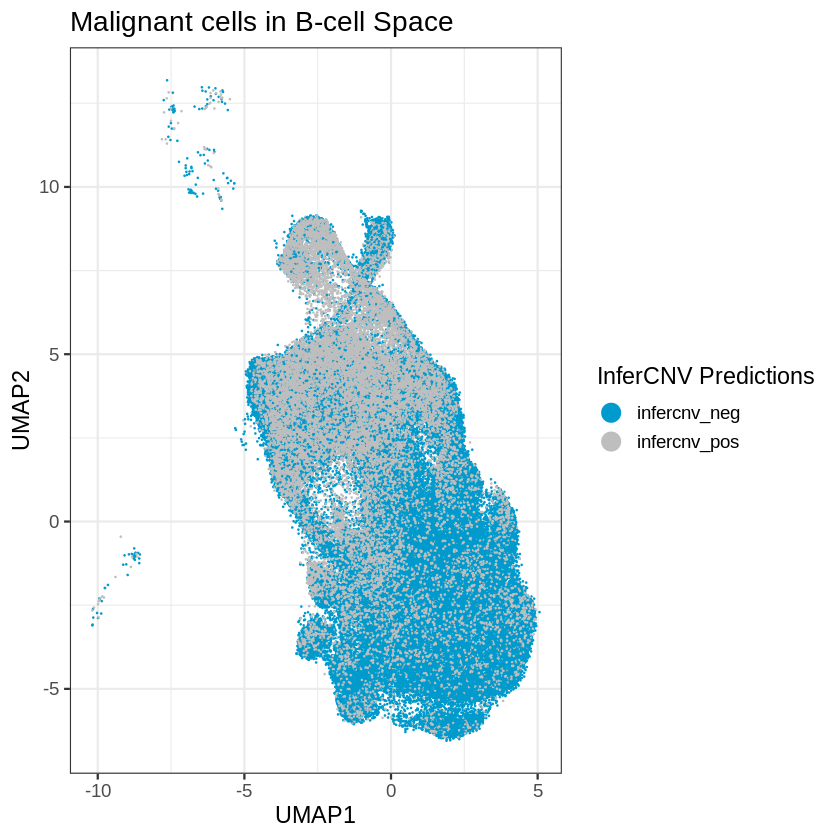

In [49]:
B_cell@meta.data  %>% 
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%   
    ggplot(aes(x = UMAP_1, y = UMAP_2)) +
    geom_point(aes(col = infercnv), size = 0.1) +
    labs(x = "UMAP1", y = "UMAP2", title = "Malignant cells in B-cell Space", col = "InferCNV Predictions") +
    scale_color_manual(values = c("deepskyblue3", "gray")) +
    theme_bw(base_size = 14)  +
    guides(color = guide_legend(override.aes = list(size = 5)))

ggsave("./results/figures/10_inferCNV_denfined_infercnv_pos_cells_B_cell_umap.pdf", width = 5, height = 4)

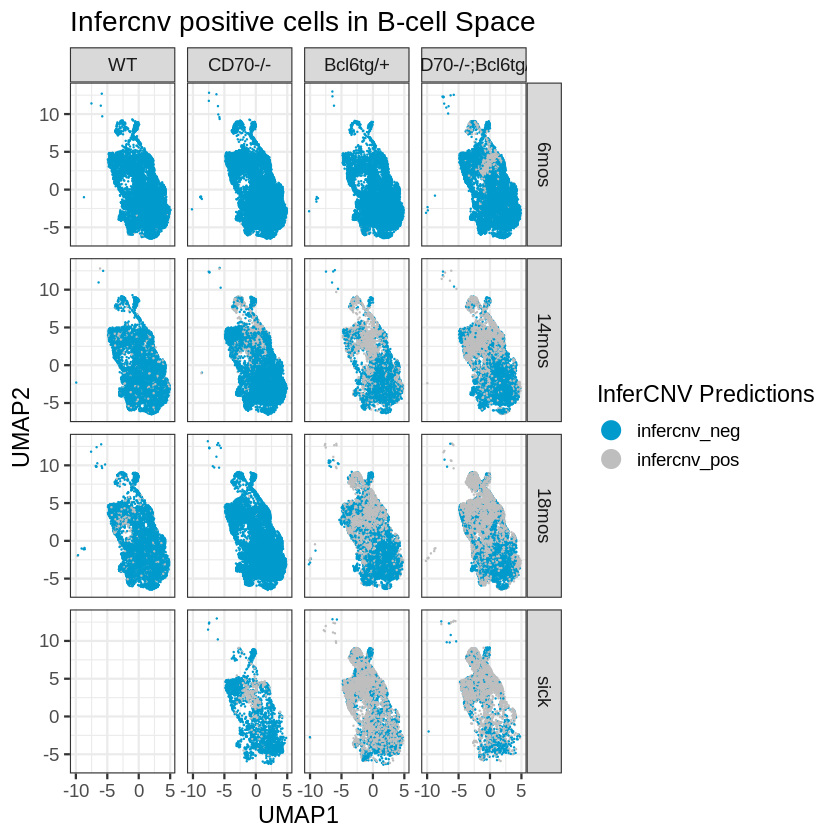

In [51]:
B_cell@meta.data  %>% 
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    ggplot(aes(x = UMAP_1, y = UMAP_2)) +
    geom_point(aes(col = infercnv), size = 0.05) +
    labs(x = "UMAP1", y = "UMAP2", title = "Infercnv positive cells in B-cell Space", col = "InferCNV Predictions") +
    scale_color_manual(values = c("deepskyblue3", "gray")) +
    theme_bw(base_size = 14)  +
    facet_grid(age ~ genotype) +
    guides(color = guide_legend(override.aes = list(size = 5)))

ggsave("./results/figures/10_inferCNV_denfined_infercnv_pos_cells_B_cell_umap_by_genotype_by_age.pdf", width = 10, height = 8)

## Q: Where are the infercnv positive cells distributed

Joining, by = "infercnv"


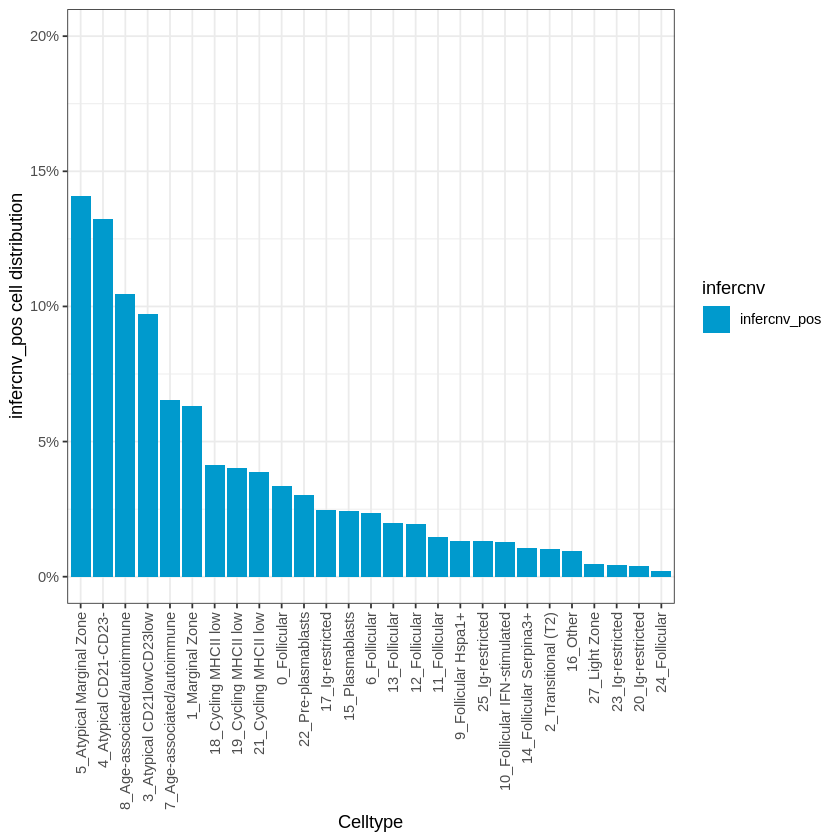

In [55]:
B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    # number of inferCNV-pos per cluster
    count(infercnv, new_annotation, name = 'n_infercnv_cluster')  %>%  
    # total number of inferCNV-pos
    left_join(B_cell@meta.data  %>%  count(infercnv))  %>% 
    # number of inferCNV-pos per cluster/total number of inferCNV-pos
    mutate(celltype_enrich = n_infercnv_cluster/n)  %>% 
    filter(infercnv == 'infercnv_pos')  %>%
    ggplot(aes(x = reorder(new_annotation, -celltype_enrich), y = celltype_enrich, fill = infercnv)) + 
    geom_bar(stat = "identity", position = 'stack') +
    theme_bw() +
    scale_fill_manual(values = c('deepskyblue3')) +
    scale_y_continuous(labels = scales::percent, limits = c(0, 0.2)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Celltype", y = "infercnv_pos cell distribution", fill = "infercnv")

ggsave("./results/figures/10_cell_type_enrichment_of_infercnv_pos_cells.pdf", width = 8, height = 8)

Joining, by = "infercnv"


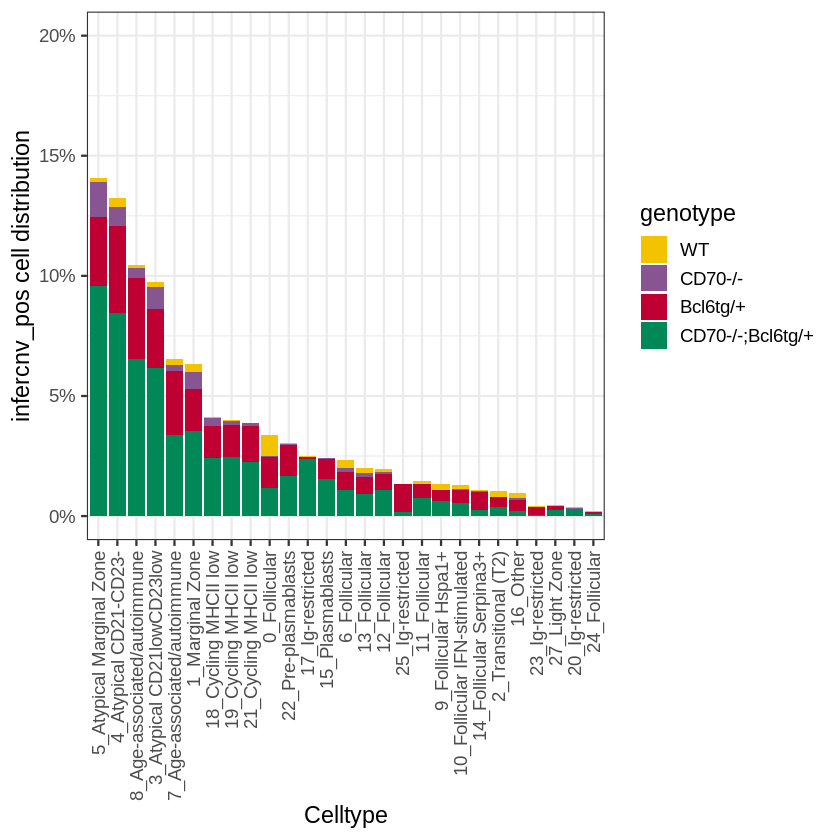

In [56]:
B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    # number of inferCNV-pos per cluster per genotype
    count(infercnv, new_annotation, genotype,name = 'n_infercnv_cluster_genotype')  %>%  
    # total number of inferCNV-pos
    left_join(B_cell@meta.data  %>%  count(infercnv))  %>% 
    # number of inferCNV-pos per cluster per genotype/total number of inferCNV-pos
    mutate(celltype_enrich = n_infercnv_cluster_genotype/n)  %>% 
    filter(infercnv == 'infercnv_pos')  %>%
    ggplot(aes(x = reorder(new_annotation, -celltype_enrich), y = celltype_enrich, fill = genotype)) + 
    geom_bar(stat = "identity", position = 'stack') +
    scale_fill_manual(values = kelly[c(3,4,7,10)]) +
    theme_bw(14) +
    scale_y_continuous(labels = scales::percent, limits = c(0, 0.2)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Celltype", y = "infercnv_pos cell distribution", fill = "genotype")

ggsave("./results/figures/10_cell_type_enrichment_of_infercnv_pos_cells_by_genotype.pdf", width = 8, height = 8)

Joining, by = "infercnv"
Warning message:
“Removed 1 rows containing missing values (geom_bar).”
Warning message:
“Removed 1 rows containing missing values (geom_bar).”


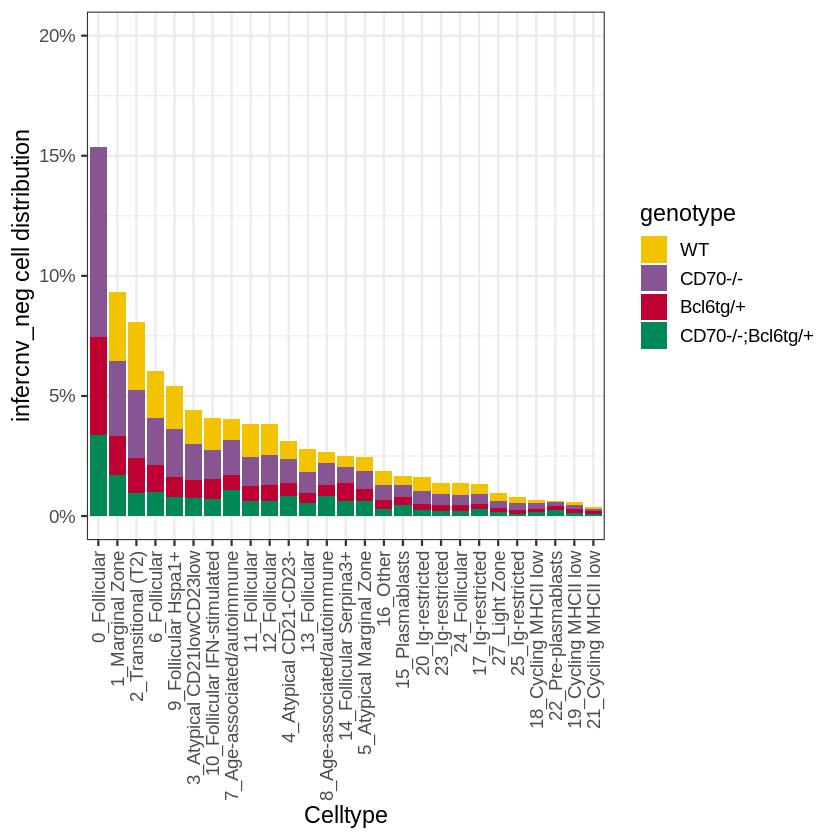

In [57]:
B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    # number of inferCNV per cluster per genotype
    count(infercnv, new_annotation, genotype,name = 'n_infercnv_cluster_genotype')  %>%  
    # total number of inferCNV-pos
    left_join(B_cell@meta.data  %>%  count(infercnv))  %>% 
    # number of inferCNV-pos per cluster per genotype/total number of inferCNV-pos
    mutate(celltype_enrich = n_infercnv_cluster_genotype/n)  %>% 
    filter(infercnv == 'infercnv_neg')  %>%
    ggplot(aes(x = reorder(new_annotation, -celltype_enrich), y = celltype_enrich, fill = genotype)) + 
    geom_bar(stat = "identity", position = 'stack') +
    scale_fill_manual(values = kelly[c(3,4,7,10)]) +
    theme_bw(14) +
    scale_y_continuous(labels = scales::percent, limits = c(0, 0.2)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Celltype", y = "infercnv_neg cell distribution", fill = "genotype")

ggsave("./results/figures/10_cell_type_enrichment_of_infercnv_neg_cells_by_genotype.pdf", width = 8, height = 8)

## Q: What are the genotypes per cluster

Joining, by = "new_annotation"
Joining, by = "new_annotation"


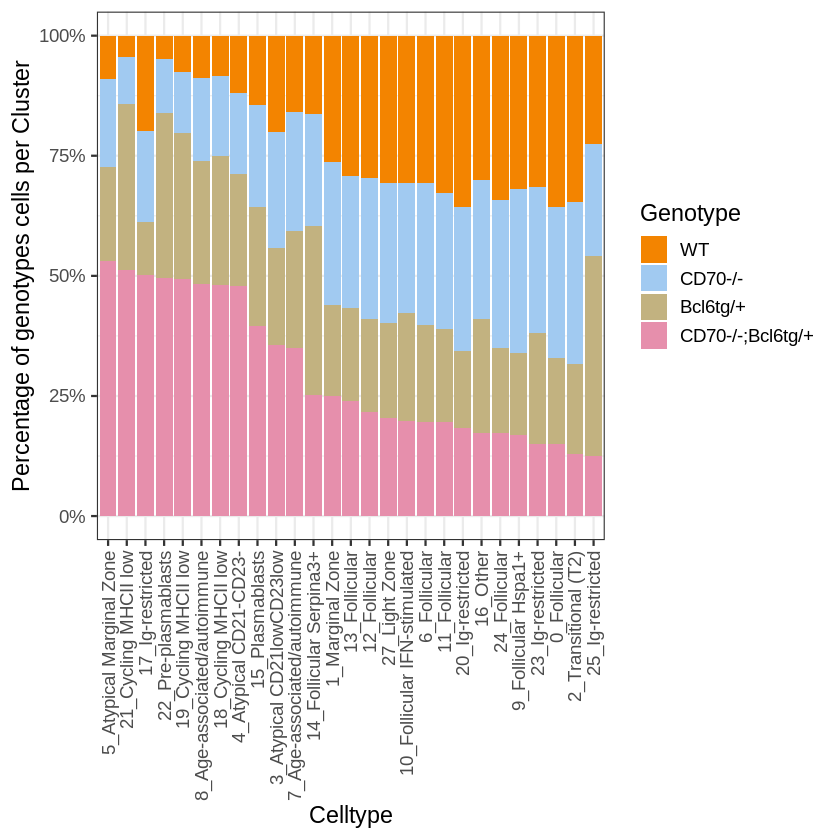

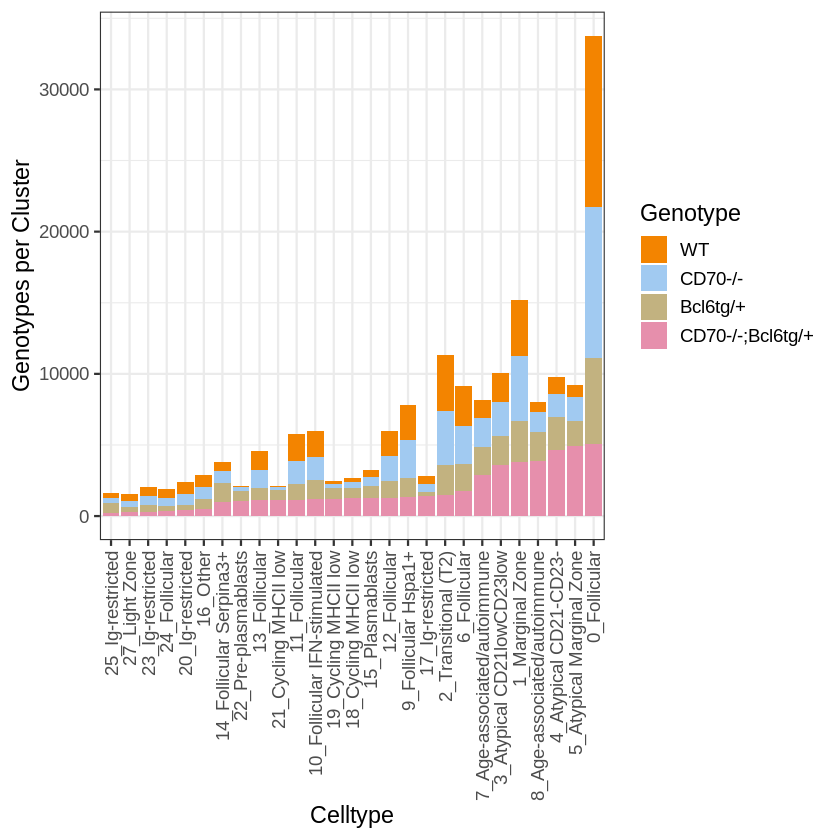

In [31]:

new_annotation_level<- B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    count(new_annotation, genotype, name = "genotype_per_cluster")   %>% 
    left_join(count(B_cell@meta.data, new_annotation, name = "total_n_cells_cluster"))  %>%
    mutate(percentage_of_genotypes = genotype_per_cluster/total_n_cells_cluster)  %>% 
    filter(genotype == "CD70-/-;Bcl6tg/+")  %>%  
    arrange(-percentage_of_genotypes) %>% pull(new_annotation)  %>% as.character()

B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    count(new_annotation, genotype, name = "genotype_per_cluster")   %>% 
    left_join(count(B_cell@meta.data, new_annotation, name = "total_n_cells_cluster"))  %>%
    mutate(percentage_of_genotypes = genotype_per_cluster/total_n_cells_cluster)  %>% 
    mutate(new_annotation = factor(new_annotation, levels = new_annotation_level))  %>% 
    ggplot(aes(x = new_annotation, y = percentage_of_genotypes, fill = genotype)) + 
    geom_bar(stat = "identity", position = 'stack') +
    scale_fill_manual(values = kelly[c(5,6,8,11)]) +
    theme_bw(14) +
    scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Celltype", y = "Percentage of genotypes cells per Cluster", fill = "Genotype")


ggsave("./results/figures/10_genotypes_per_annotation_percentage.pdf", width = 8, height = 8)


new_annotation_level<- B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    count(new_annotation, genotype, name = "genotype_per_cluster")   %>% 
    filter(genotype == "CD70-/-;Bcl6tg/+")  %>%  
    arrange(genotype_per_cluster) %>% pull(new_annotation)  %>% as.character()

B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    count(new_annotation, genotype, name = "genotype_per_cluster")   %>% 
    mutate(new_annotation = factor(new_annotation, levels = new_annotation_level))  %>% 
    ggplot(aes(x = new_annotation, y = genotype_per_cluster, fill = genotype)) + 
    geom_bar(stat = "identity", position = 'stack') +
    scale_fill_manual(values = kelly[c(5,6,8,11)]) +
    theme_bw(14) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Celltype", y = "Genotypes per Cluster", fill = "Genotype")


ggsave("./results/figures/10_genotypes_per_annotation.pdf", width = 8, height = 8)

Joining, by = c("genotype", "infercnv")
Joining, by = c("genotype", "infercnv")


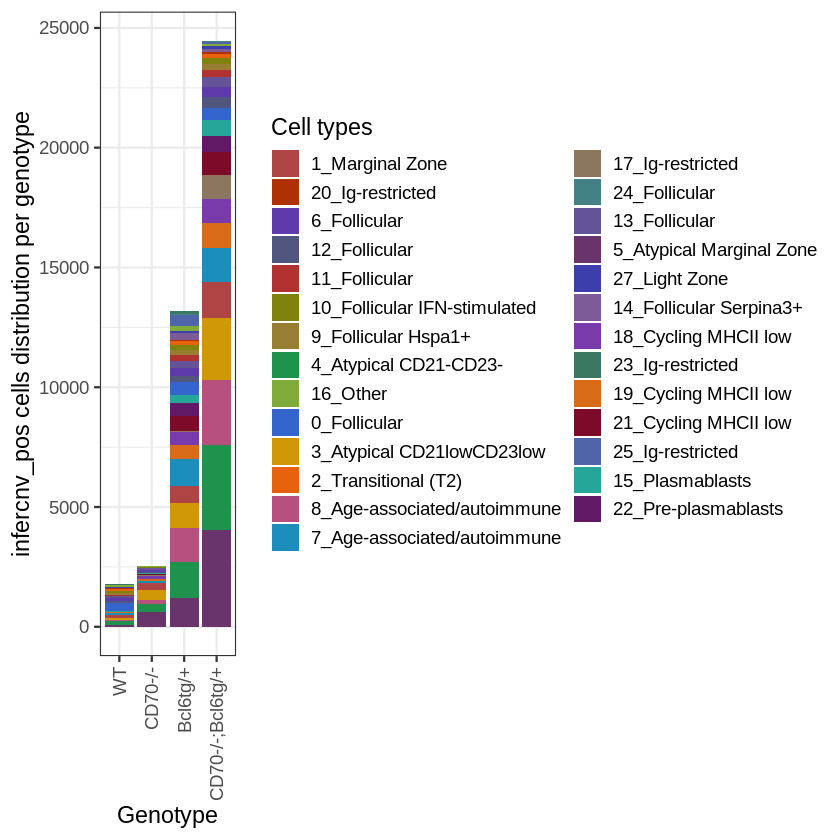

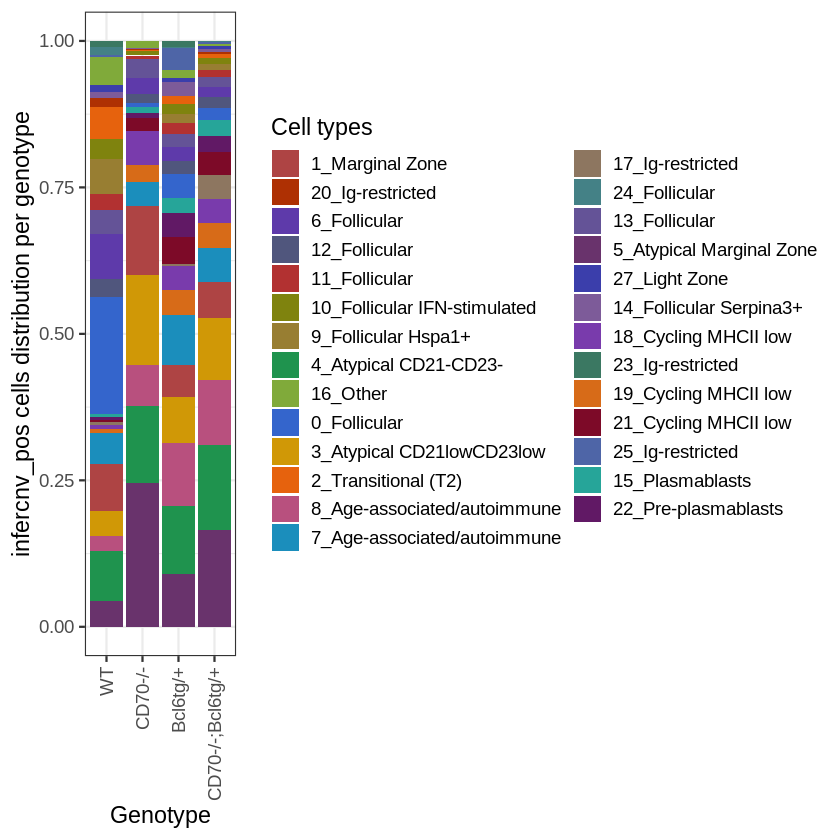

In [58]:
colors = B_cell@meta.data  %>% distinct(HEX_code, new_annotation)  %>% pull(HEX_code)
names(colors) = B_cell@meta.data  %>% distinct(HEX_code, new_annotation)  %>% pull(new_annotation)

new_annotation_level<- B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    filter(infercnv == "infercnv_pos")  %>% 
    count(genotype, new_annotation, name = "infercnv_pos_cell_dist_per_genotype")  %>%
    filter(genotype == "CD70-/-;Bcl6tg/+")  %>% 
    arrange(infercnv_pos_cell_dist_per_genotype) %>% pull(new_annotation)  %>% as.character()


B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    filter(infercnv == "infercnv_pos")  %>% 
    count(genotype, new_annotation, name = "infercnv_pos_cell_dist_per_genotype")  %>% 
    mutate(new_annotation = factor(new_annotation, levels = new_annotation_level))  %>% 
    ggplot(aes(x = genotype, y = infercnv_pos_cell_dist_per_genotype, fill = new_annotation)) +
    geom_bar(stat = "identity", position = 'stack') +
    theme_bw(14) +
    scale_fill_manual(values = colors) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Genotype", y = "infercnv_pos cells distribution per genotype", fill = "Cell types")

ggsave("./results/figures/10_infercnv_pos_cell_dist_per_genotype.pdf", width = 10, height = 8)


colors = B_cell@meta.data  %>% distinct(HEX_code, new_annotation)  %>% pull(HEX_code)
names(colors) = B_cell@meta.data  %>% distinct(HEX_code, new_annotation)  %>% pull(new_annotation)

new_annotation_level<- B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    count(genotype, new_annotation, infercnv, name = "infercnv_pos_cell_dist_per_genotype")  %>%
    left_join(count(B_cell@meta.data, genotype, infercnv, name = "n_infercnv_pos_cells_per_genotype"))  %>%
    mutate(percentage_of_infercnv_pos_clusters_per_genotypes = infercnv_pos_cell_dist_per_genotype/n_infercnv_pos_cells_per_genotype)  %>% 
    filter(infercnv == 'infercnv_pos')  %>% 
    filter(genotype == "CD70-/-;Bcl6tg/+")  %>%
    arrange(percentage_of_infercnv_pos_clusters_per_genotypes) %>% pull(new_annotation)  %>% as.character()


B_cell@meta.data  %>%
    count(genotype, new_annotation, infercnv, name = "infercnv_pos_cell_dist_per_genotype")  %>%
    left_join(count(B_cell@meta.data, genotype, infercnv, name = "n_infercnv_pos_cells_per_genotype"))  %>%
    mutate(percentage_of_infercnv_pos_clusters_per_genotypes = infercnv_pos_cell_dist_per_genotype/n_infercnv_pos_cells_per_genotype)  %>% 
    filter(infercnv == 'infercnv_pos')  %>%
    mutate(new_annotation = factor(new_annotation, levels = new_annotation_level))  %>% 
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    ggplot(aes(x = genotype, y = percentage_of_infercnv_pos_clusters_per_genotypes, fill = new_annotation)) +
    geom_bar(stat = "identity", position = 'stack') +
    theme_bw(14) +
    scale_fill_manual(values = colors) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Genotype", y = "infercnv_pos cells distribution per genotype", fill = "Cell types")

ggsave("./results/figures/10_percentage_infercnv_pos_cell_dist_per_genotype.pdf", width = 10, height = 8)

Joining, by = c("age", "infercnv")
Joining, by = c("age", "infercnv")


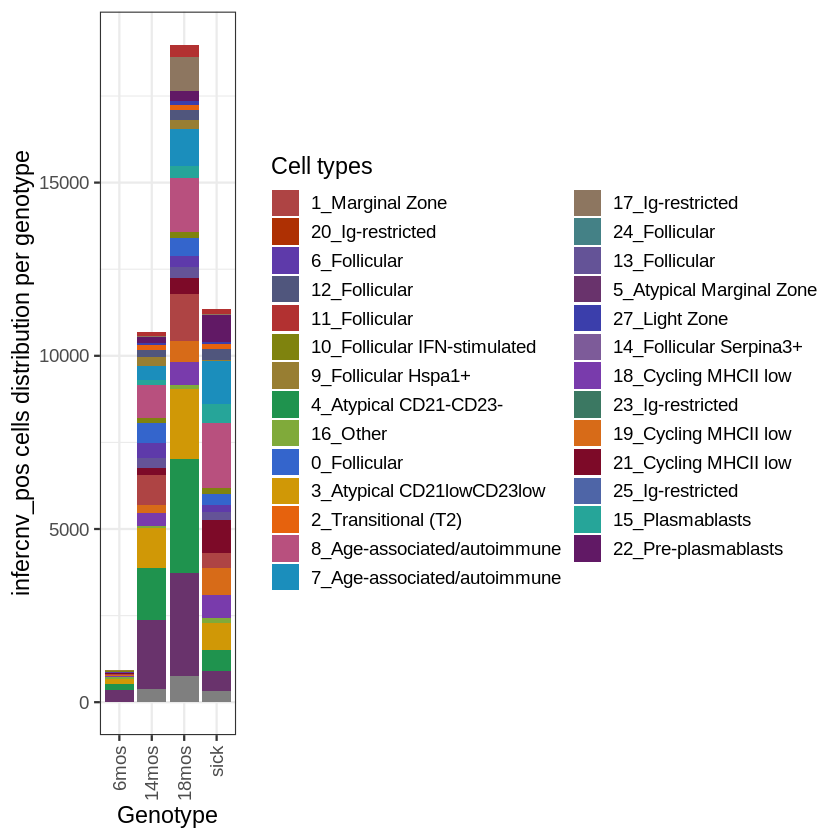

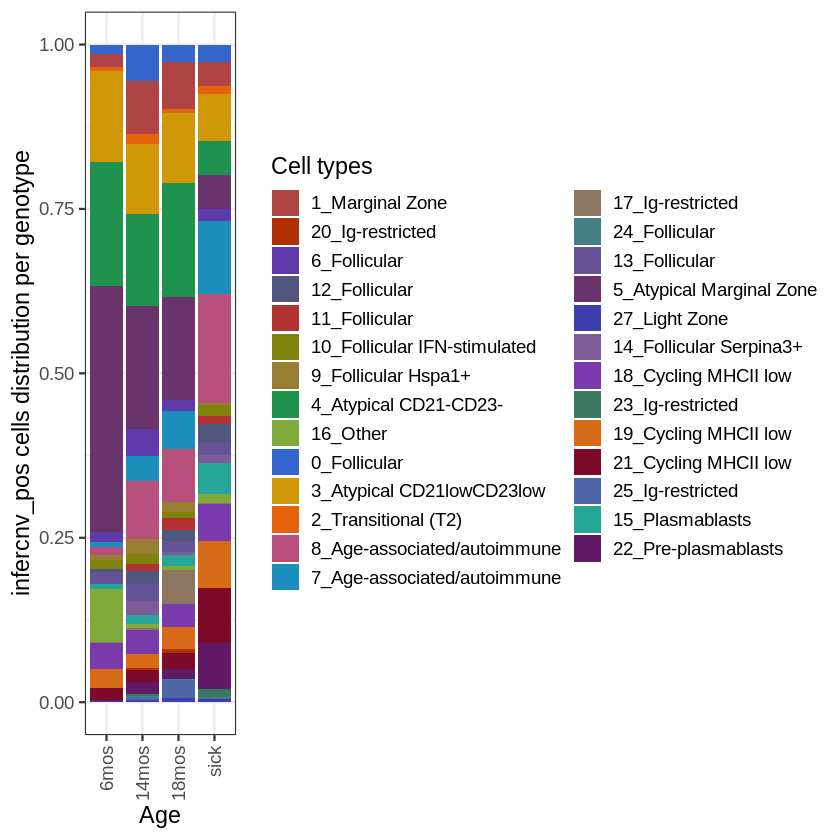

In [59]:
colors = B_cell@meta.data  %>% distinct(HEX_code, new_annotation)  %>% pull(HEX_code)
names(colors) = B_cell@meta.data  %>% distinct(HEX_code, new_annotation)  %>% pull(new_annotation)

new_annotation_level<- B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    filter(infercnv == "infercnv_pos")  %>% 
    count(age, new_annotation, name = "infercnv_pos_cell_dist_per_age")  %>%
    filter(age == "6mos")  %>% 
    arrange(infercnv_pos_cell_dist_per_age) %>% pull(new_annotation)  %>% as.character()


B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    filter(infercnv == "infercnv_pos")  %>% 
    count(age, new_annotation, name = "infercnv_pos_cell_dist_per_age")  %>%
    mutate(new_annotation = factor(new_annotation, levels = new_annotation_level))  %>% 
    ggplot(aes(x = age, y = infercnv_pos_cell_dist_per_age, fill = new_annotation)) +
    geom_bar(stat = "identity", position = 'stack') +
    theme_bw(14) +
    scale_fill_manual(values = colors) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Genotype", y = "infercnv_pos cells distribution per genotype", fill = "Cell types")

ggsave("./results/figures/10_infercnv_pos_cell_dist_per_age.pdf", width = 10, height = 8)


new_annotation_level<- B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    count(age, new_annotation, infercnv, name = "infercnv_pos_cell_dist_per_age")  %>%
    left_join(count(B_cell@meta.data, age, infercnv, name = "n_infercnv_pos_cells_per_age"))  %>%
    mutate(percentage_of_infercnv_pos_clusters_per_age = infercnv_pos_cell_dist_per_age/n_infercnv_pos_cells_per_age)  %>% 
    filter(infercnv == 'infercnv_pos')  %>% 
    filter(age == "6mos")  %>%
    arrange(percentage_of_infercnv_pos_clusters_per_age) %>% pull(new_annotation)  %>% as.character()


B_cell@meta.data  %>%
    count(age, new_annotation, infercnv, name = "infercnv_pos_cell_dist_per_age")  %>%
    left_join(count(B_cell@meta.data, age, infercnv, name = "n_infercnv_pos_cells_per_age"))  %>%
    mutate(percentage_of_infercnv_pos_clusters_per_age = infercnv_pos_cell_dist_per_age/n_infercnv_pos_cells_per_age)  %>% 
    filter(infercnv == 'infercnv_pos')  %>% 
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    ggplot(aes(x = age, y = percentage_of_infercnv_pos_clusters_per_age, fill = new_annotation)) +
    geom_bar(stat = "identity", position = 'stack') +
    theme_bw(14) +
    scale_fill_manual(values = colors) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Age", y = "infercnv_pos cells distribution per genotype", fill = "Cell types")

ggsave("./results/figures/10_percentage_infercnv_pos_cell_dist_per_age.pdf", width = 10, height = 8)

## Q: What percentage of the cells are malignant in each cluster

Joining, by = "new_annotation"
Joining, by = "new_annotation"


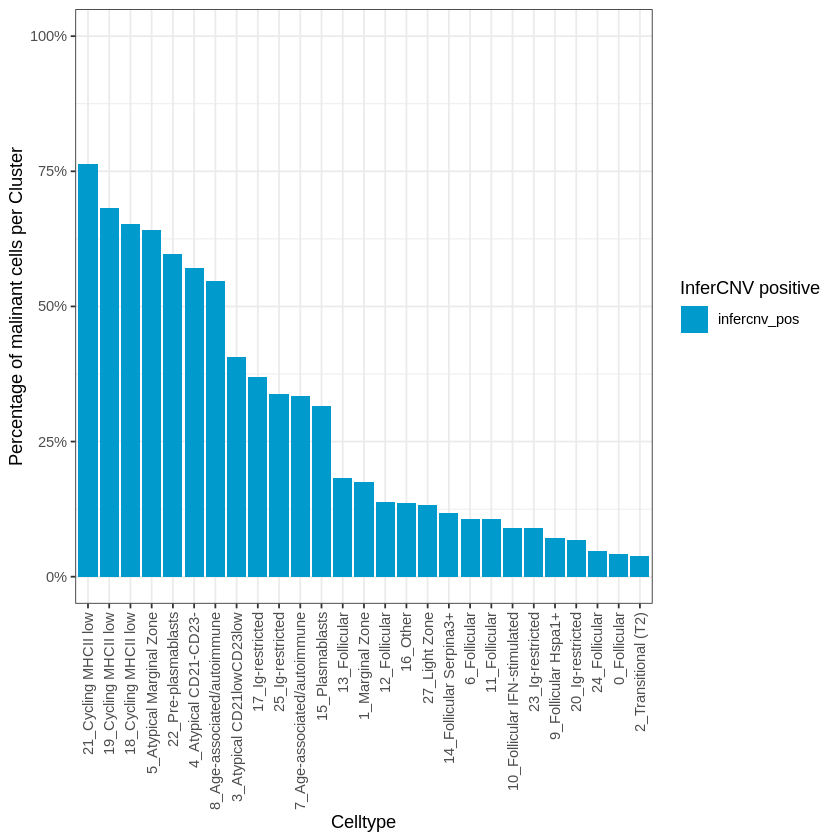

In [60]:
new_annotation_level<- 
    B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    count(infercnv, new_annotation, name = "n_infercnv_pos_cells_cluster")  %>% 
    left_join(count(B_cell@meta.data, new_annotation, name = "total_n_cells_cluster"))  %>%
    # total number of inferCNV-pos per cluster/total number of cells per cluster
    mutate(percentage_infercnv_pos_cell_cluster = n_infercnv_pos_cells_cluster/total_n_cells_cluster)   %>% 
    filter(infercnv == "infercnv_pos")  %>%
    arrange(-percentage_infercnv_pos_cell_cluster)  %>% pull(new_annotation)

B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    count(infercnv, new_annotation, name = "n_infercnv_pos_cells_cluster")  %>% 
    left_join(count(B_cell@meta.data, new_annotation, name = "total_n_cells_cluster"))  %>%
    # total number of inferCNV-pos per cluster/total number of cells per cluster
    mutate(percentage_infercnv_pos_cell_cluster = n_infercnv_pos_cells_cluster/total_n_cells_cluster)   %>%
    mutate(new_annotation = factor(new_annotation, levels = new_annotation_level))  %>% 
    filter(infercnv == "infercnv_pos")  %>%
    ggplot(aes(x = new_annotation, y = percentage_infercnv_pos_cell_cluster, fill = infercnv)) + 
    geom_bar(stat = "identity", position = 'stack') +
    scale_fill_manual(values = c('deepskyblue3')) +
    theme_bw() +
    scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Celltype", y = "Percentage of malinant cells per Cluster", fill = "InferCNV positive")

ggsave("./results/figures/10_inferCNV_percentage_of_infercnv_pos_cells_per_annotation.pdf", width = 8, height = 8)

Joining, by = "new_annotation"


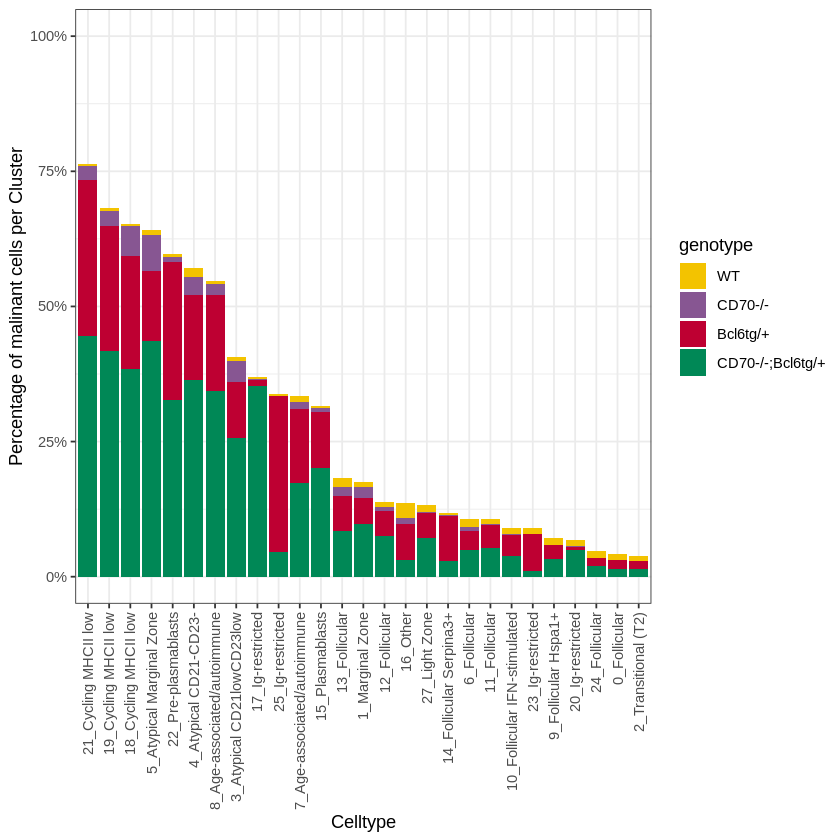

In [61]:
B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    count(infercnv, new_annotation, genotype, name = "n_infercnv_pos_cells_cluster")  %>% 
    left_join(count(B_cell@meta.data, new_annotation, name = "total_n_cells_cluster"))  %>%
    # total number of inferCNV-pos per cluster/total number of cells per cluster
    mutate(percentage_infercnv_pos_cell_cluster = n_infercnv_pos_cells_cluster/total_n_cells_cluster)   %>%
    mutate(new_annotation = factor(new_annotation, levels = new_annotation_level))  %>% 
    filter(infercnv == "infercnv_pos")  %>%
    ggplot(aes(x = new_annotation, y = percentage_infercnv_pos_cell_cluster, fill = genotype)) + 
    geom_bar(stat = "identity", position = 'stack') +
    scale_fill_manual(values = kelly[c(3,4,7,10)]) +
    theme_bw() +
    scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Celltype", y = "Percentage of malinant cells per Cluster", fill = "genotype")

ggsave("./results/figures/10_inferCNV_percentage_of_infercnv_pos_cells_per_annotation_by_genotype.pdf", width = 8, height = 8)

Joining, by = "new_annotation"


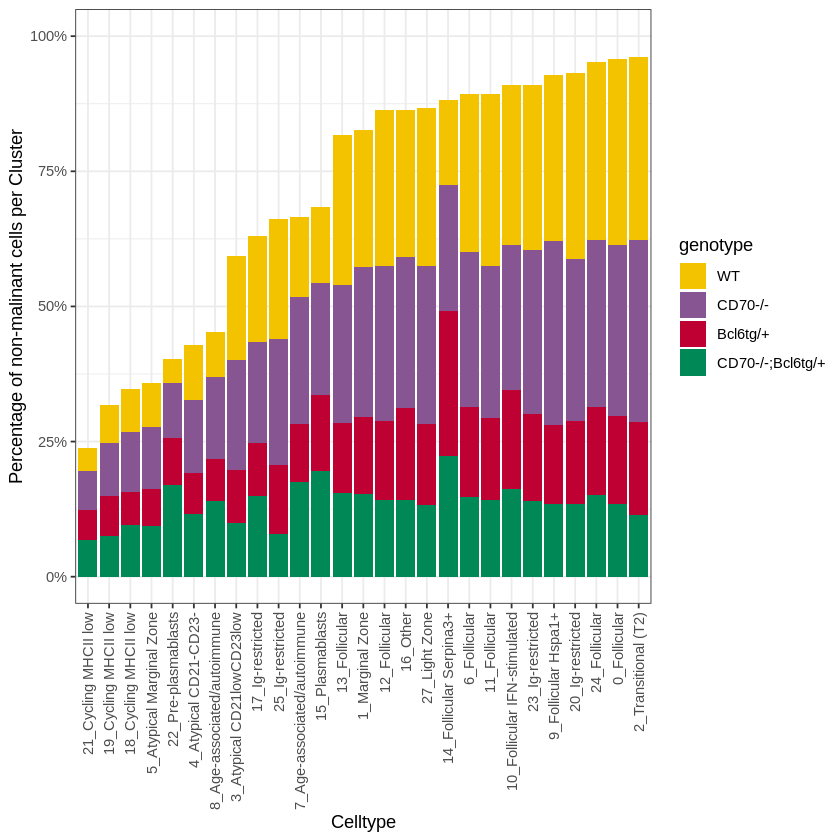

In [62]:
B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    count(infercnv, new_annotation, genotype, name = "n_malignant_cells_cluster")  %>% 
    left_join(count(B_cell@meta.data, new_annotation, name = "total_n_cells_cluster"))  %>%
    # total number of inferCNV-pos per cluster/total number of cells per cluster
    mutate(percentage_malignant_cell_cluster = n_malignant_cells_cluster/total_n_cells_cluster)   %>%
    mutate(new_annotation = factor(new_annotation, levels = new_annotation_level))  %>% 
    filter(infercnv == "infercnv_neg")  %>%
    ggplot(aes(x = new_annotation, y = percentage_malignant_cell_cluster, fill = genotype)) + 
    geom_bar(stat = "identity", position = 'stack') +
    scale_fill_manual(values = kelly[c(3,4,7,10)]) +
    theme_bw() +
    scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Celltype", y = "Percentage of non-malinant cells per Cluster", fill = "genotype")

ggsave("./results/figures/10_inferCNV_percentage_of_infercnv_neg_cells_per_annotation_by_genotype.pdf", width = 8, height = 8)

Joining, by = "new_annotation"
Joining, by = "new_annotation"


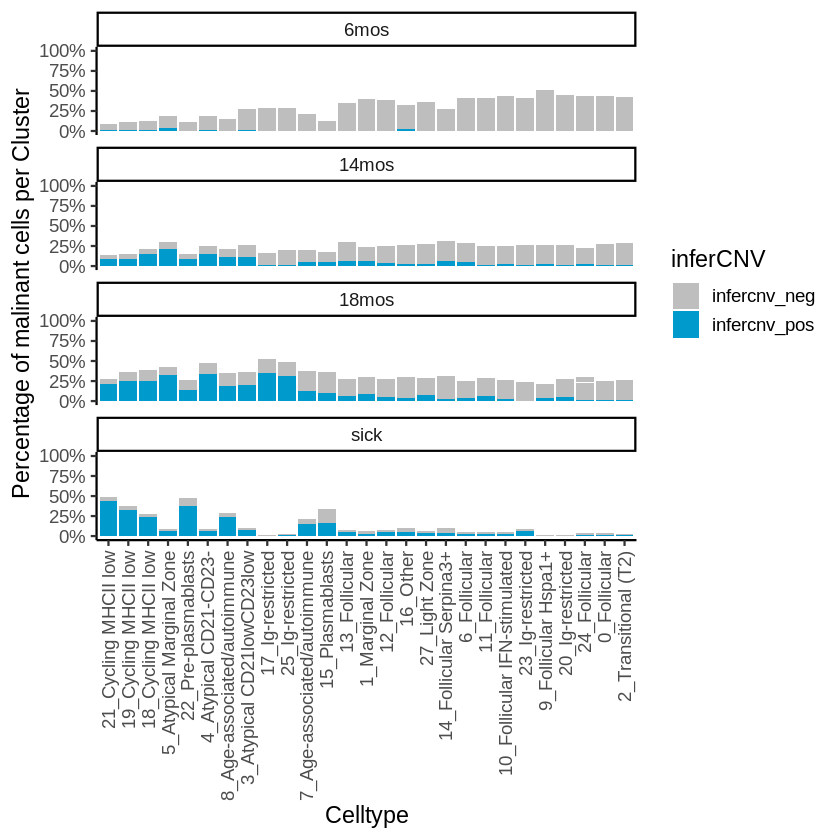

Joining, by = "new_annotation"


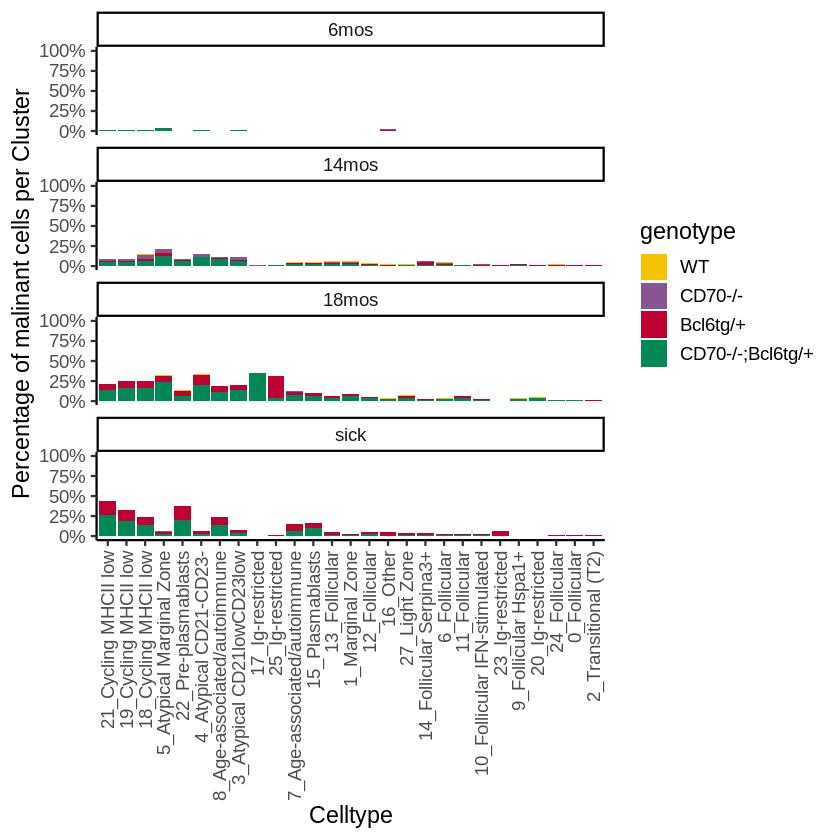

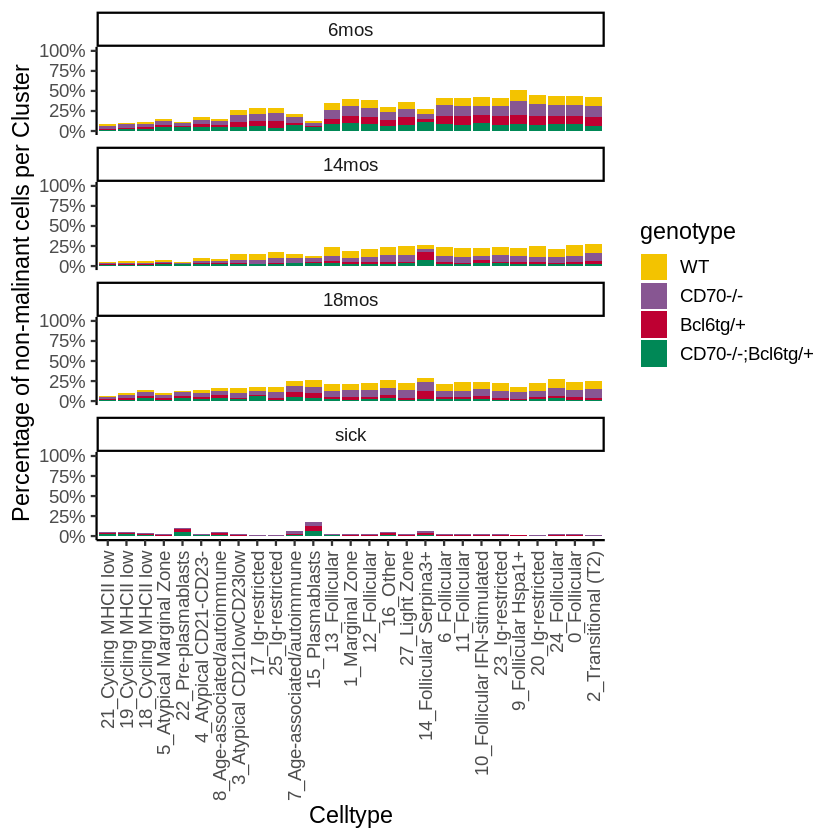

In [63]:
B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    # n of infercnv_pos cells per mouse per cluster
    count(infercnv, new_annotation, age, genotype, name = "n_infercnv_pos_cells_cluster_sample")  %>% 
    left_join(count(B_cell@meta.data, new_annotation, name = "total_n_cells_cluster"))  %>%
    # n of infercnv_pos cells per mouse per cluster/ n cells per cluster
    mutate(percentage_infercnv_pos_cell_cluster = n_infercnv_pos_cells_cluster_sample/total_n_cells_cluster)   %>%
    mutate(infercnv = factor(infercnv, levels = c("infercnv_neg", "infercnv_pos")))  %>%
    mutate(new_annotation = factor(new_annotation, levels = new_annotation_level))  %>%
    ggplot(aes(x = new_annotation, y = percentage_infercnv_pos_cell_cluster, fill = infercnv)) + 
    geom_bar(stat = "identity", position = 'stack') +
    scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
    scale_fill_manual(values = c("gray",'deepskyblue3')) +
    facet_wrap( ~ age, scale= "free_y", ncol = 1) +
    theme_classic(base_size = 14) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Celltype", y = "Percentage of malinant cells per Cluster", fill = "inferCNV")

ggsave("./results/figures/10_inferCNV_percentage_of_infercnv_pos_cells_per_annotation_by_age.pdf", width = 8, height = 10)


B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    count(infercnv, new_annotation, age, genotype, name = "n_infercnv_pos_cells_cluster_sample")  %>% 
    left_join(count(B_cell@meta.data, new_annotation, name = "total_n_cells_cluster"))  %>%
    mutate(percentage_infercnv_pos_cell_cluster = n_infercnv_pos_cells_cluster_sample/total_n_cells_cluster)   %>%
    mutate(infercnv = factor(infercnv, levels = c("infercnv_neg", "infercnv_pos")))  %>%
    mutate(new_annotation = factor(new_annotation, levels = new_annotation_level))  %>%
    filter(infercnv == "infercnv_pos")  %>%
    ggplot(aes(x = new_annotation, y = percentage_infercnv_pos_cell_cluster, fill = genotype)) + 
    geom_bar(stat = "identity", position = 'stack') +
    scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
    scale_fill_manual(values =kelly[c(3,4,7,10)]) +
    facet_wrap( ~ age, scale= "free_y", ncol = 1) +
    theme_classic(base_size = 14) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Celltype", y = "Percentage of malinant cells per Cluster", fill = "genotype")

ggsave("./results/figures/10_inferCNV_percentage_of_infercnv_pos_cells_per_annotation_by_age_by_genotype.pdf", width = 8, height = 10)


B_cell@meta.data  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    count(infercnv, new_annotation, age, genotype, name = "n_infercnv_pos_cells_cluster_sample")  %>% 
    left_join(count(B_cell@meta.data, new_annotation, name = "total_n_cells_cluster"))  %>%
    mutate(percentage_infercnv_pos_cell_cluster = n_infercnv_pos_cells_cluster_sample/total_n_cells_cluster)   %>%
    mutate(infercnv = factor(infercnv, levels = c("infercnv_neg", "infercnv_pos")))  %>%
    mutate(new_annotation = factor(new_annotation, levels = new_annotation_level))  %>%
    filter(infercnv == "infercnv_neg")  %>%
    ggplot(aes(x = new_annotation, y = percentage_infercnv_pos_cell_cluster, fill = genotype)) + 
    geom_bar(stat = "identity", position = 'stack') +
    scale_y_continuous(labels = scales::percent, limits = c(0, 1)) +
    scale_fill_manual(values =kelly[c(3,4,7,10)]) +
    facet_wrap( ~ age, scale= "free_y", ncol = 1) +
    theme_classic(base_size = 14) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(x = "Celltype", y = "Percentage of non-malinant cells per Cluster", fill = "genotype")

ggsave("./results/figures/10_inferCNV_percentage_of_infercnv_neg_cells_per_annotation_by_age_by_genotype.pdf", width = 8, height = 10)

In [64]:
df_genotype_age <- B_cell@meta.data  %>%
    # n of infercnv_pos cells per mouse
    count(infercnv, age, genotype, name = "n_infercnv_pos_cells_per_genotype_age")  %>% 
     # total n of cells per mouse
    left_join(count(B_cell@meta.data, age, genotype, name = "total_n_cells_per_genotype_age"))  %>%
    mutate(age = factor(age, levels = c("6mos", "14mos", "18mos", "sick")))  %>% 
    mutate(genotype = factor(genotype, levels = c("WT", "CD70-/-", "Bcl6tg/+", "CD70-/-;Bcl6tg/+")))  %>%
    # percentage of infercnv_pos cells per mouse
    mutate(percentage_infercnv_pos_cell_per_genotype_age = n_infercnv_pos_cells_per_genotype_age/total_n_cells_per_genotype_age) %>%
    filter(infercnv == "infercnv_pos")  %>%
    select(age, genotype, percentage_infercnv_pos_cell_per_genotype_age)  %>% 
    arrange(age, genotype, percentage_infercnv_pos_cell_per_genotype_age)

write.table(x = df_genotype_age, file = './data/infercnv/10_percentage_of_infercnv_pos_cells_per_genotype_per_age_new.tsv', 
            quote = FALSE, sep = '\t', row.names = FALSE, col.names = TRUE)

Joining, by = c("age", "genotype")


In [65]:
library(rBCS)
saveRDS(B_cell, "./data/objects/B_cell_inferCNV_positive_annotated.rds")
ExportSeurat(B_cell, "./data/objects/B_cell_inferCNV_positive_annotated.bcs", overwrite=TRUE)

Warning message in ValidateInput():
“B_cell_inferCNV_positive_annotated.bcs will be replaced”


[2025-03-27 20:12:02] Initializing... 
[2025-03-27 20:12:02] Extracting expressions... 
[2025-03-27 20:12:02] Extracting metadata... 
[2025-03-27 20:12:02] Extracting dimred... 
[2025-03-27 20:12:02] Writing data... 


Warning message in dir.create(file.path(study.path, "main"), recursive = TRUE):
“'304eea21-121a-40d6-8ceb-31316a3fa5f2/main' already exists”


[2025-03-27 20:12:02] Writing column sums... 
[2025-03-27 20:12:06] Writing matrices... 
[2025-03-27 20:14:52] Writing metadata... 
[2025-03-27 20:15:02] Writing cell embeddings... 
[2025-03-27 20:15:04] Writing intermediate embeddings... 


You created a large dataset with compression and chunking.
The chunk size is equal to the dataset dimensions.
If you want to read subsets of the dataset, you should testsmaller chunk sizes to improve read times.

You created a large dataset with compression and chunking.
The chunk size is equal to the dataset dimensions.
If you want to read subsets of the dataset, you should testsmaller chunk sizes to improve read times.



[2025-03-27 20:15:13] Writing general information... 
[2025-03-27 20:15:13] Compressing data... 


[1] TRUE